# Optimization Problem

The optimization problem can be written as:

$$
\text{min} \quad \sum_{t} \left( r x_t + q u_t \right)
$$

Subject to the following constraints:

$$
u_t + k s_t = G_t \quad \forall t \quad \text{(Demand constraint)}
$$

$$
c_{t+1} = c_t + s_t \quad \forall t \quad \text{(Storage evolution)}
$$

$$
c_T = c_0 \quad \text{(Final charge constraint)}
$$

$$
x_{t+1} = x_t + L_t - u_t \quad \forall t \quad \text{(Workload evolution)}
$$


$$
x_T = 0 \quad \text{(Backlog clearance)}
$$

$$
x_t, c_t, u_t \geq 0 \quad \forall t \quad \text{(Non-negativity)}
$$


Where:
- \( x_t \): backlog or deferred workload at time \( t \)
- \( u_t \): amount of workload processed at time \( t \)
- \( r \): cost per unit of backlog — penalizes unprocessed/delayed work
- \( q \): cost per unit of processing — energy, labor, or other operational costs
- \( L_t \): new workload arriving at time \( t \)


## Constraints

### Demand Constraint:
$$
u_t + k s_t = G_t \quad \forall t
$$

Where:
- \( G_t \): power consumption (e.g., grid energy) at time \( t \)
- \( s_t \): power stored into battery at time \( t \)
- \( k \): conversion factor between storage and power (e.g., efficiency)

### Storage Evolution:
$$
c_{t+1} = c_t + s_t \quad \forall t
$$

### Final Charge Constraint:
$$
c_T = c_0
$$

### Workload Evolution:
$$
x_{t+1} = x_t + L_t - u_t \quad \forall t
$$

Where:
- \( L_t \): new workload arriving at time \( t \)

### Backlog Clearance:
$$
x_T = 0
$$

### Non-Negativity:
$$
x_t \geq 0, \quad c_t \geq 0, \quad u_t \geq 0 \quad \forall t
$$

## Summary
This linear program determines:
- Workload processing decisions (\( u_t \))
- Energy usage and storage (\( s_t \), \( c_t \))
- Backlog management (\( x_t \))

All while minimizing the total cost from both deferred (\( r x_t \)) and completed work (\( q u_t \)), under operational and physical constraints.


# Incorporating Cooling

We assume that all electricity used for computing purposes is generated into heat, and the heat removed/cooled is the same as the heat generated:

$$
\dot{Q}_{load} = \dot{W}_{computing} = \dot{Q}_{cooling}
$$

Thus, 
$$
P_{chiller}(t) = \frac{\dot{Q}_{cooling}(t)}{COP(T_{ambient}(t))}
$$

From literature (Yu 2005 and Zhang 2024), we determine a relationship between COP and ambient temperature:
$$
COP(T_{ambient}(t)) = COP_{ref} \cdot (1-0.02(T_{ambient} - T_{ref}))
$$

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import warnings
warnings.filterwarnings('ignore')


def find_data_start_line(file_path):
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if line.startswith('DATA PERIODS'):
                # Data starts on the next line
                return i + 2

# Path to your .epw file

# Column names for EPW hourly data (standard 35 fields)
column_names = [
    "Year", "Month", "Day", "Hour", "Minute", "Data Source and Uncertainty Flags",
    "Dry Bulb Temperature [C]", "Dew Point Temperature [C]", "Relative Humidity [%]",
    "Atmospheric Station Pressure [Pa]", "Extraterrestrial Horizontal Radiation [Wh/m2]",
    "Extraterrestrial Direct Normal Radiation [Wh/m2]",
    "Horizontal Infrared Radiation Intensity [Wh/m2]", "Global Horizontal Radiation [Wh/m2]",
    "Direct Normal Radiation [Wh/m2]", "Diffuse Horizontal Radiation [Wh/m2]",
    "Global Horizontal Illuminance [lux]", "Direct Normal Illuminance [lux]",
    "Diffuse Horizontal Illuminance [lux]", "Zenith Luminance [Cd/m2]",
    "Wind Direction [degrees]", "Wind Speed [m/s]", "Total Sky Cover [tenths]",
    "Opaque Sky Cover [tenths]", "Visibility [km]", "Ceiling Height [m]",
    "Present Weather Observation", "Present Weather Codes", "Precipitable Water [mm]",
    "Aerosol Optical Depth [thousandths]", "Snow Depth [cm]", "Days Since Last Snowfall",
    "Albedo", "Liquid Precipitation Depth [mm]", "Liquid Precipitation Quantity [hr]"
]

def shift_from_utc(data, offset_hours):
    """
    Shift a list of 24 hourly values from UTC to a timezone that is `offset_hours`
    behind UTC.

    """
    # roll left by offset_hours:
    k = offset_hours % 24
    return data[k:] + data[:k]


def get_data(energy_path,weather_path, offset, DC_wind_cap, DC_solar_cap, iso_wind_cap, iso_solar_cap):
    """
    Loads renewable generation and carbon intensity data, and computes
    DC-area wind and solar generation adjusted for UTC offset.

    Parameters:
        path (str): Path to CSV file containing renewable generation data.
        offset (int): Hours to shift from UTC.
        DC_wind_cap (float): DC-area wind capacity.
        DC_solar_cap (float): DC-area solar capacity.
        iso_wind_cap (float): ISO-wide wind capacity.
        iso_solar_cap (float): ISO-wide solar capacity.

    Returns:
        tuple: Shifted DC wind generation, DC solar generation, and grid carbon intensity (lists).
    """
    renewable_gen = pd.read_csv(energy_path)
    skip_rows = find_data_start_line(weather_path)
    weather_data = pd.read_csv(weather_path, skiprows=skip_rows, header=None, names=column_names)
    temperature = weather_data["Dry Bulb Temperature [C]"].to_list()

    iso_wind = renewable_gen["WND"]
    iso_solar = renewable_gen["SUN"]

    # Normalize ISO generation and scale to DC capacities
    DC_wind_gen = shift_from_utc(((iso_wind / iso_wind_cap) * DC_wind_cap).tolist(), offset)
    DC_solar_gen = shift_from_utc(((iso_solar / iso_solar_cap) * DC_solar_cap).tolist(), offset)

    # Shift carbon intensity values
    grid_carbon = shift_from_utc(renewable_gen["avg_CI"].tolist(), offset)

    return DC_wind_gen, DC_solar_gen, grid_carbon, temperature

import pandas as pd
import numpy as np

def interpolate_array(arr):
    """
    Takes a list with numeric values and missing entries (None, np.nan, or non-numeric strings),
    and returns a new list with linear interpolation filling in the missing values.
    """
    # Convert to pandas Series, coerce bad values to NaN
    series = pd.to_numeric(pd.Series(arr), errors='coerce')

    # Interpolate missing values
    interpolated = series.interpolate()

    # Optional: fill any NaNs at the start or end
    interpolated = interpolated.fillna(method='bfill').fillna(method='ffill')

    return interpolated.tolist()

def interp(list):
    for index, value in enumerate(list):
        if np.isnan(value):
            list[index] = (list[index-1]+list[index+1])/2
    return list

price_per_MWh = 40
SCC = 190
renewable_path = "data/CarbonIntensity/CAISO_NG_&_avgCI.csv"
weather_path = 'data/Weather/USA_CA_San.Jose-Mineta.epw'
T = 24*365-1
W, S, C, T_amb = get_data(renewable_path, weather_path, 8 , 100,500,6200,21000,)
C = interpolate_array(C)
Carbon_ton_mwh = [C[i]/1e3 for i in range(len(C)) ]
T_amb = np.array(T_amb[:T])

In [126]:
load_path = "data/Workload/load_profile_template_edited(Google).csv"
load = pd.read_csv(load_path)
load.head()
load_kw = load["Load (kW)"]
L = (load_kw/1000).to_list()
L=L[:T]


### Helper functions (for visualizations)

In [127]:
def plot_results(title, served, load, soc=None, generation=None, backlog=None,
                 carbon_intensity=None, emissions=None):

    T = len(served)
    L=load[:T]
    total_demand = sum(L)
    total_served = sum(served)
    total_emissions = sum(emissions) if emissions else None

    # Collect secondary plots
    secondary_plots = []
    if generation: secondary_plots.append(('Generation Over Time', generation[:T], 'Power (kW)', 'green'))
    if soc: secondary_plots.append(('Battery State of Charge', soc[:T], 'Stored Energy (% of Capacity)', 'purple'))
    if backlog: secondary_plots.append(('Backlog Over Time', backlog[:T], 'Energy(MW)', 'crimson'))
    if carbon_intensity: secondary_plots.append(('Carbon Intensity Over Time', carbon_intensity[:T], 'tons CO₂ / MWh', 'gray'))
    if emissions: secondary_plots.append(('Emissions Over Time', emissions[:T], 'tons CO₂', 'black'))

    num_rows = 1 + len(secondary_plots)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, 4 * num_rows), squeeze=False)

    # Plot 1: Load and Served
    ax_main = axs[0, 0]
    ax_main.plot(range(len(L)), L, marker="o", label="Load (Demand, MW)", color="blue")
    ax_main.plot(range(len(served)), served, marker="o", label="Served", color="orange")
    ax_main.fill_between(range(len(L)), 0, L, alpha=0.1, color="blue")
    ax_main.fill_between(range(len(served)), 0, served, alpha=0.2, color="orange")
    ax_main.set_title(title)
    ax_main.set_xlabel("Time Step")
    ax_main.set_ylabel("Energy")
    ax_main.grid(True)
    ax_main.legend()

    text = f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}"
    if total_emissions is not None:
        text += f"\nTotal Emissions = {total_emissions:.1f} kgCO₂"
    ax_main.text(len(L) - 2, max(max(L), max(served)) * 0.85,
                text, bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # Plot each additional element in its own row
    for i, (title_i, data_i, y_label, color) in enumerate(secondary_plots, start=1):
        ax = axs[i, 0]
        ax.plot(range(len(data_i)), data_i, marker='o', color=color, label=title_i)
        ax.fill_between(range(len(data_i)), 0, data_i, color=color, alpha=0.15)
        ax.set_title(title_i)
        ax.set_xlabel("Time Step")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_duals_and_reduced_costs(duals, reduced_costs):
    time_range = range(len(next(iter(duals.values())))) if duals else range(len(next(iter(reduced_costs.values()))))

    # Plot all dual variables in one figure
    if duals:
        n_plots = len(duals)
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))

        # If there's only one plot, axes is an array with one element. We handle that case separately
        if n_plots == 1:
            axes = [axes]

        # Plot each dual variable in a separate subplot
        colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
        i = 0
        for name, values in duals.items():
            ax = axes[i]
            ax.plot(time_range, values,color = colors[i], marker='o',linestyle='--', label=f"Dual: {name}")
            ax.set_title(f"Dual Variable: {name}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Dual Value")
            ax.grid(True)
            ax.legend()
            i += 1

        # Adjust layout and show all plots
        plt.tight_layout()
        plt.show()

    # Plot all reduced costs in a separate figure
    if reduced_costs:
        n_plots = len(reduced_costs)
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))

        # If there's only one plot, axes is an array with one element. We handle that case separately
        if n_plots == 1:
            axes = [axes]

        # Plot each dual variable in a separate subplot
        i = 0
        for name, values in reduced_costs.items():
            ax = axes[i]
            ax.plot(range(len(values)), values,color = colors[i], marker='o',linestyle='--', label=f"Dual: {name}")
            ax.set_title(f"Reduced cost: {name}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Dual Value")
            ax.grid(True)
            ax.legend()
            i += 1

        # Adjust layout and show all plots
        plt.tight_layout()
        plt.show()


def plot_results_1(title, served, soc=None, second_plot=None, backlog=None,
                   carbon_intensity=None, emissions=None,
                   from_renewables=None, from_storage=None, from_grid=None,
                   duals=None, reduced_costs=None):

    total_demand = sum(L)
    total_served = sum(served)
    total_emissions = sum(emissions) if emissions else None

    # Secondary plots
    secondary_plots = []
    if second_plot: secondary_plots.append(('Generation Over Time', G, 'Power (kW)', 'green'))
    if soc: secondary_plots.append(('Battery State of Charge', soc, 'Stored Energy', 'purple'))
    if backlog: secondary_plots.append(('Backlog Over Time', backlog, 'Energy', 'crimson'))
    if carbon_intensity: secondary_plots.append(('Carbon Intensity Over Time', carbon_intensity, 'kg CO₂ / MWh', 'gray'))
    if emissions: secondary_plots.append(('Emissions Over Time', emissions, 'kg CO₂', 'black'))

    num_rows = 1 + len(secondary_plots)
    fig, axs = plt.subplots(num_rows, 1, figsize=(10, 4 * num_rows), squeeze=False)

    # Plot 1: Load and Served
    ax_main = axs[0, 0]
    time_range = range(len(L))
    ax_main.plot(time_range, L, marker="o", label="Load (Demand)", color="blue")
    ax_main.fill_between(time_range, 0, L, alpha=0.1, color="blue")

    # Prepare stacking if any source is present
    source_stack = []
    source_labels = []
    source_colors = []

    if from_renewables:
        source_stack.append(from_renewables)
        source_labels.append("Renewables")
        source_colors.append("lightgreen")

    if from_storage:
        if source_stack:
            stacked_storage = [source_stack[-1][i] + from_storage[i] for i in time_range]
        else:
            stacked_storage = from_storage
        source_stack.append(stacked_storage)
        source_labels.append("Storage")
        source_colors.append("purple")

    if from_grid:
        if source_stack:
            stacked_grid = [source_stack[-1][i] + from_grid[i] for i in time_range]
        else:
            stacked_grid = from_grid
        source_stack.append(stacked_grid)
        source_labels.append("Grid")
        source_colors.append("gray")

    # Plot stacked sources if any exist
    if source_stack:
        bottom = [0] * len(L)
        for i, top in enumerate(source_stack):
            ax_main.fill_between(time_range, bottom, top,
                                 label=source_labels[i],
                                 color=source_colors[i], alpha=0.6)
            bottom = top
        ax_main.plot(time_range, served, marker="o", color="orange", label="Served (Total)")
    else:
        ax_main.plot(range(len(served)), served, marker="o", label="Served", color="orange")
        ax_main.fill_between(range(len(served)), 0, served, alpha=0.2, color="orange")

    ax_main.set_title(title)
    ax_main.set_xlabel("Time Step")
    ax_main.set_ylabel("Energy")
    ax_main.grid(True)
    ax_main.legend()

    # Summary text
    text = f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}"
    if total_emissions is not None:
        text += f"\nTotal Emissions = {total_emissions:.1f} kgCO₂"
    ax_main.text(len(L) - 2, max(max(L), max(served)) * 0.85,
                 text, bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # Plot additional variables
    for i, (title_i, data_i, y_label, color) in enumerate(secondary_plots, start=1):
        ax = axs[i, 0]
        ax.plot(range(len(data_i)), data_i, marker='o', color=color, label=title_i)
        ax.fill_between(range(len(data_i)), 0, data_i, color=color, alpha=0.15)
        ax.set_title(title_i)
        ax.set_xlabel("Time Step")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Plot duals and reduced costs separately
    if duals or reduced_costs:
        plot_duals_and_reduced_costs(duals, reduced_costs)


### Actual Scenarios

In [128]:
q = 1.0  # Cost per unit energy used
r = 200  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit =100 # float("inf") #or switch to actual computing limit
battery_limit = 300 # float("inf") # or switch to actual computing limit

## Grid Dependent

### No Job scheduling

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# Input data (already loaded from previous context)
# Parameters

# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
# L = [
#     30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50,
#     55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
# ]  # Computational Load sum = 1400
# G = [
#      0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
#    143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
# ]  #Renewable Generation sum = 1526


In [130]:

# Assume all demand is served by the grid
CAPEX = 2100*1000

# Parameters
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = 4.07 # float("inf") # or switch to actual computing limit


hours = np.arange(T)
T_ref, COP_ref = 25.0, 4.0
# T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m1 = gp.Model("Grid + Storage w/ Optimal Scheduling")
m1.setParam("OutputFlag", 0)

u_g = m1.addVars(T, name="u_g", lb=0)
P_chiller = m1.addVars(T, name="P_chiller", lb=0)
u = m1.addVars(T, name="u", lb=0)

# Add constraints
m1.addConstrs((u[t] == L[t] for t in range(T)), name="compute_limit")
m1.addConstrs((COP[t] * P_chiller[t] >= u[t] for t in range(T)), name="cooling_req")
m1.addConstrs((u_g[t] == u[t] + P_chiller[t] for t in range(T)), name="energy_balance")

# Set objective to minimize total carbon cost
m1.setObjective(gp.quicksum(u_g[t] * C[t] for t in range(T)), GRB.MINIMIZE)
m1.optimize()

# Post-processing and results
if m1.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 1:")

    served_1 = [u[t].X for t in range(T)]
    emissions_1 = [u_g[t].X * Carbon_ton_mwh[t] for t in range(T)]
    total_cost_grid = sum((u_g[t].X*price_per_MWh for t in range(len(served_1))))
    print(f"Total cost of grid usage:$ {total_cost_grid/(1e6) :.2f} M")
    print(f"Total cost of carbon: $ {sum(emissions_1) * 50/1e6:.2f} M")
    print(f"Yearly Cost: $ {total_cost_grid/(1e6)+sum(emissions_1) * 50/1e6 :.2f} M")
    # plot_results("Scenario 1: Grid Dependent DC w/ Workload Scheduling", served_1, carbon_intensity=C, emissions=emissions_1)



Optimal Schedule for Scenario 1:
Total cost of grid usage:$ 28.84 M
Total cost of carbon: $ 9.21 M
Yearly Cost: $ 38.05 M


### With Job Scheduling

In [131]:
# Assume all demand is served by the grid
CAPEX_Storage = 2100*1e3
CAPEX_Solar = 1482*1e3
CAPEX_Wind = 1665*1e3
# Parameters
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = float("inf") # or switch to actual computing limit


hours = np.arange(T)
T_ref, COP_ref = 25.0, 4.0
# T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m1 = gp.Model("Grid + Storage w/ Optimal Scheduling")
m1.setParam("OutputFlag",0)

u_g = m1.addVars(T,name= "u_g",lb=0) # power associated with grid use
x = m1.addVars(T+1,name="x",lb=0) # Backlog
P_chiller = m1.addVars(T, name="P_chiller", lb=0) # cooling load
u = m1.addVars(T, name="u", lb=0) # computing load

#Initial Conditions
m1.addConstr(x[0]==0,"initial backlog")

#Terminal Conditions

# Dynamics and constraints
m1.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m1.addConstrs((u[t] <= computing_limit for t in range(T)),name="compute_limit")
m1.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m1.addConstrs((u_g[t] == u[t] + P_chiller[t]  for t in range(T)), name="energy_balance")

for t_day in range(23, T+1, 24):  # at hour 24, 48, ..., T
    m1.addConstr(x[t_day] == 0, name=f"end_of_day_backlog_{t_day}")

m1.setObjective(gp.quicksum(u_g[t]*Carbon_ton_mwh[t] for t in range(T)), GRB.MINIMIZE)
m1.optimize()


if m1.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 1:")

    served_1 = [u[t].X for t in range(T)]  # Energy served to meet the load
    backlog_1 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_1 = [u_g[t].X * Carbon_ton_mwh[t] for t in range(T)]
    total_cost_grid = sum((u_g[t].X*price_per_MWh for t in range(len(served_1))))
    print(f"Total cost of grid usage:$ {total_cost_grid/(1e6) :.2f} M")
    print(f"Total cost of carbon: $ {sum(emissions_1) * SCC/1e6:.2f} M")
    print(f"Yearly Cost: $ {total_cost_grid/(1e6)+sum(emissions_1) * SCC/1e6 :.2f} M")
    # plot_results("Scenario 1: Grid Dependent DC w/ Workload Scheduling", served_1, backlog = backlog_1, carbon_intensity=C, emissions=emissions_1)
    # plot_results("Scenario 1: Grid Dependent DC w/ Workload Scheduling", served_1,L,backlog = backlog_1,carbon_intensity=Carbon_ton_mwh, emissions=emissions_1)



Optimal Schedule for Scenario 1:
Total cost of grid usage:$ 28.97 M
Total cost of carbon: $ 31.74 M
Yearly Cost: $ 60.71 M


In [132]:
print(sum(L))

COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))
P_chiller = [L[i]/COP[i] for i in range(len(L))]
print(sum(S)/(sum(P_chiller)+sum(L)))

595089.0658484
nan



Optimal Schedule for Scenario 2:
Optimum wind capacity : 647.97 MW
Optimum solar capacity : 0.00 MW
AEP : 3251.32 MWh
Optimum battery capacity : 15.58 MW
Percent Energy lost: 54.36 %
total demand served 1483.97 MW
total actual demand: 595089.07 MW
Percentage of Demand Served: 100.00 %
Solar Capex: $ 0.00 M
Wind Capex: $ 1078.86 M
Storage CAPEX: $ 420.00 M
Total Costs: $ 1498.86M


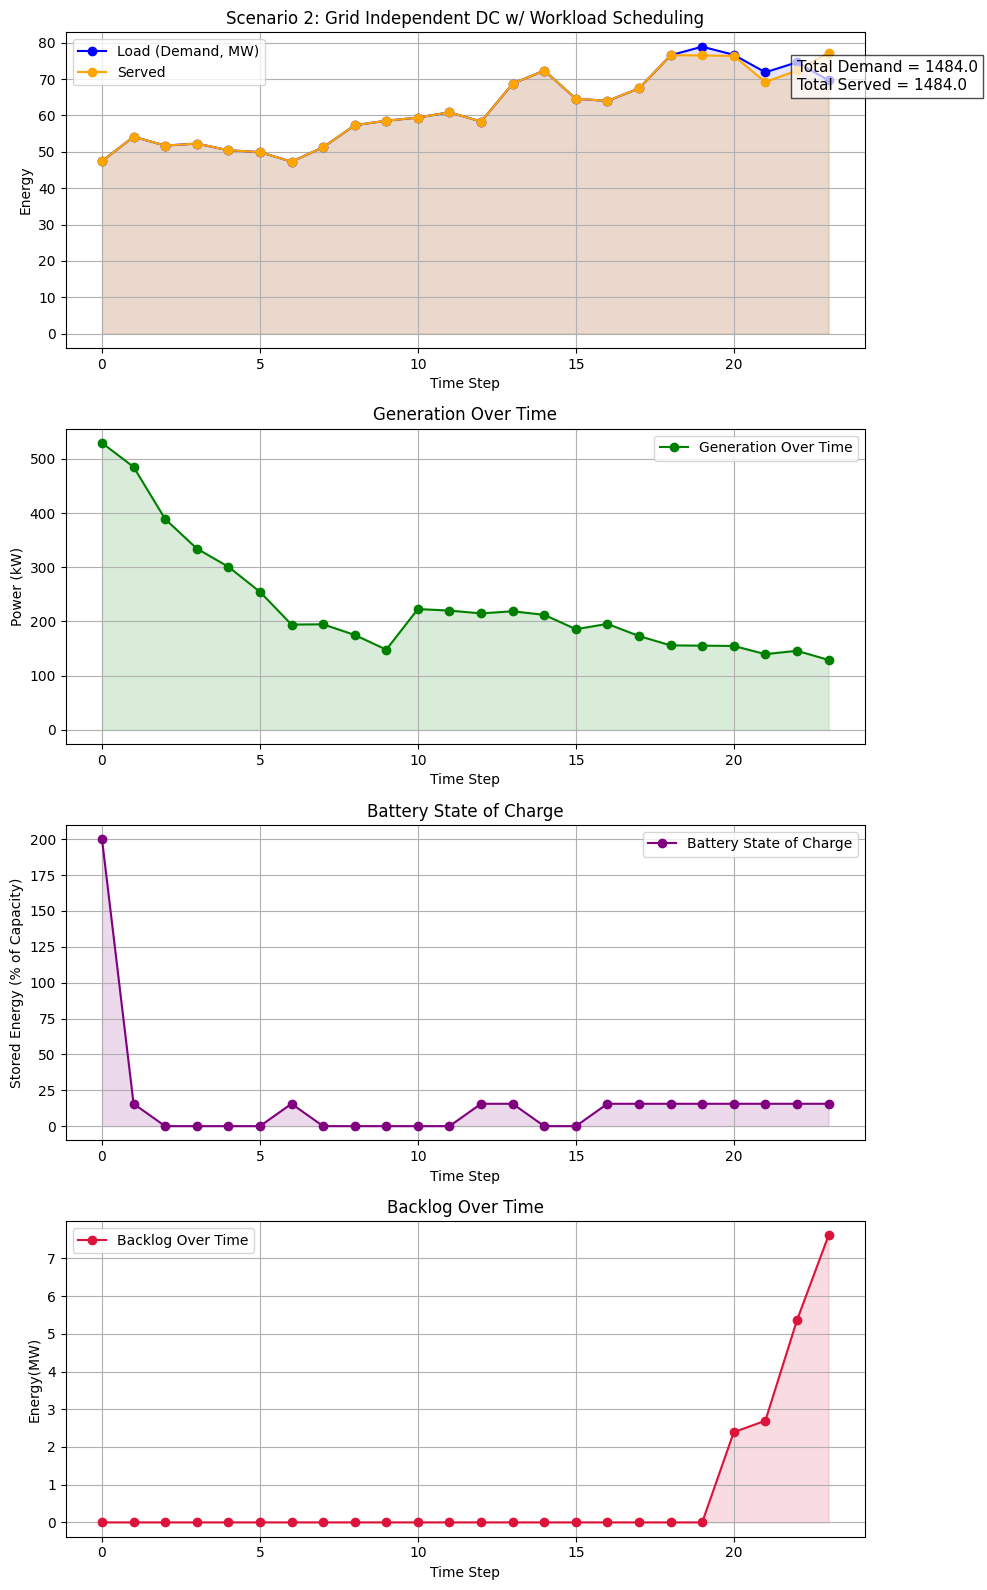

In [147]:


m2 = gp.Model("Cooling + Grid + Storage + Renewables Optimal Scheduling")
m2.setParam("OutputFlag",0)
solar_capacity_val = 1.0  # unit MW
wind_capacity_val = 1.0
battery_limit = m2.addVar(name="Battery Capacity",lb=0)
W, S, _, _ = get_data(renewable_path, weather_path, 8 , wind_capacity_val,solar_capacity_val,6200,21000,)

S_unit = interpolate_array(S)
W_unit = interpolate_array(W)

solar_capacity = m2.addVar(name="Solar Capacity",lb=0,)
wind_capacity = m2.addVar(name="Solar Capacity",lb=0)

T = 24#*365-1
u_r = m2.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m2.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
s_discharge = m2.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m2.addVars(T+1,name="x",lb=0) # Backlog
c = m2.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m2.addVars(T, name="P_chiller", lb=0) # cooling load
u = m2.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m2.addConstr(x[0]==0,"initial backlog")
m2.addConstr(c[0]==200,"inital storage")

#Terminal Conditions
# m2.addConstr(x[T] <= x[0], "terminal_backlog")

# Dynamics and constraints

m2.addConstrs((c[t+1] == c[t] + s_charge_r[t] - s_discharge[t] for t in range(T)), name="soc_update")
m2.addConstrs((c[t+1] <= battery_limit for t in range(T)), name="storage_capacity")
m2.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name="max_discharge")
m2.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m2.addConstrs((u[t] <= 100 for t in range(T)),name="compute_limit")
m2.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m2.addConstrs((u_r[t] + s_charge_r[t] == S_unit[t] * solar_capacity+W_unit[t]*wind_capacity for t in range(T)), name="renewables_balance")
m2.addConstrs((u_r[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_r[t] for t in range(T)), name="energy_balance")
# for t_day in range(24, T+1, 24):  # at hour 24, 48, ..., T
m2.addConstr(c[T] == 0, "terminal_storage")
m2.addConstr(x[T] == 0, name=f"terminal_backlog")




m2.setObjective(gp.quicksum(r*x[t] for t in range(T))+CAPEX_Solar*solar_capacity+CAPEX_Storage*battery_limit + CAPEX_Wind*wind_capacity, GRB.MINIMIZE)

m2.optimize()


if m2.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 2:")
    generation_2 = [S_unit[t]*solar_capacity.X + W_unit[t]*wind_capacity.X for t in range(T)]
    served_2 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_2 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_2 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    print(f"Optimum wind capacity : {wind_capacity.X :.2f} MW")
    print(f"Optimum solar capacity : {solar_capacity.X :.2f} MW")
    print(f"AEP : {sum(generation_2) :.2f} MWh")
    print(f"Optimum battery capacity : {battery_limit.X :.2f} MW")
    print(f"Percent Energy lost: {(sum(generation_2)-sum(served_2))/(sum(generation_2))*100 :.2f} %")
    print(f"total demand served {sum(served_2) :.2f} MW")
    print(f"total actual demand: {sum(L):.2f} MW")
    print(f"Percentage of Demand Served: {sum(served_2)/sum(L[:T])*100 :.2f} %")
    solar_cost = CAPEX_Solar*solar_capacity.X/1e6
    battery_cost = CAPEX_Storage*max(soc_2)/1e6
    wind_cost = CAPEX_Wind*wind_capacity.X/1e6
    print(f"Solar Capex: $ {solar_cost :.2f} M")
    print(f"Wind Capex: $ {wind_cost :.2f} M")
    print(f"Storage CAPEX: $ {battery_cost :.2f} M")
    print(f"Total Costs: $ {solar_cost+battery_cost+wind_cost :.2f}M")
    plot_results("Scenario 2: Grid Independent DC w/ Workload Scheduling", served_2,L, soc=soc_2, generation=generation,backlog = backlog_2)


The main cost comes from capital expenditures, over time this might change

# Semi autonomous

In [ ]:
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
eta_c = 0.95
eta_d = 0.9
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = 100.281  # float("inf") # or switch to actual computing limit
memory_limit = 60 # channe this for later




hours = np.arange(T)
T_ref, COP_ref = 25.0, 4.0
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

m3 = gp.Model("Cooling + Grid + Storage + Renewables Optimal Scheduling")
m3.setParam("OutputFlag",0)
solar_capacity_val_3 = 1.0  # unit MW
wind_capacity_val_3 = 1.0
battery_limit_3 = m3.addVar(name="Battery Capacity",lb=0)
W, S, _, _ = get_data(renewable_path, weather_path, 8 , wind_capacity_val,solar_capacity_val,6200,21000,)

S_unit_3 = interpolate_array(S)
W_unit_3 = interpolate_array(W)

solar_capacity_3 = m3.addVar(name="Solar Capacity",lb=0,ub=0)
wind_capacity_3 = m3.addVar(name="Solar Capacity",lb=0,ub=400)


u_g = m3.addVars(T,name= "u_g",lb=0) # power associated with grid use
u_r = m3.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m3.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
s_charge_g = m3.addVars(T,name="s_charge_g",lb=0) # charge associated with grid
s_discharge = m3.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m3.addVars(T+1,name="x",lb=0) # Backlog
c = m3.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m3.addVars(T, name="P_chiller", lb=0) # cooling load
u = m3.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m3.addConstr(x[0]==0,"initial backlog")
m3.addConstr(c[0]==0,"inital storage")

#Terminal Conditions
m3.addConstr(c[T] >= 0, "terminal_storage")
m3.addConstr(x[T] <= x[0], "terminal_backlog")

# Dynamics and constraints
m3.addConstrs((c[t+1] == c[t] + eta_c*(s_charge_r[t] + s_charge_g[t]) - (1/eta_d)*(s_discharge[t]) for t in range(T)), name=f"soc_update")
m3.addConstrs((c[t+1] <= battery_limit for t in range(T)), name=f"storage_capacity")
m3.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name=f"max_discharge")
m3.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name=f"backlog_update")
m3.addConstrs((x[t] <= memory_limit for t in range(T)), name=f"max_backlog")
m3.addConstrs((u[t] <= 100 for t in range(T)),name=f"compute_limit")
m3.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name=f"cooling_req")
m3.addConstrs((u_r[t] + s_charge_r[t] == G[t] for t in range(T)),name=f"renewables_balance")
m3.addConstrs((u_g[t] + u_r[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_r[t] + s_charge_g[t] for t in range(T)), name=f"energy_balance")


m3.setObjective(gp.quicksum(u_g[t]*C[t]*SCC + r*x[t] for t in range(T)), GRB.MINIMIZE)
m3.optimize()


if m3.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 3:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")

    served_3 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_3 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_3 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_3 = [u_g[t].X * C[t] for t in range(T)]

    plot_results("Combo DC", served_3, soc=soc_3, second_plot=True,backlog = backlog_3, carbon_intensity=C, emissions=emissions_3)


GurobiError: Constant is Nan

# Optimization Problem


# Optimization Problem

The optimization problem can be written as:

$$
\text{min} \quad \sum_{t} \left( r x_t + q u_t \right)
$$

Subject to the following constraints:

$$
u_t + k s_t = G_t \quad \forall t \quad \text{(Demand constraint)}
$$

$$
c_{t+1} = c_t + s_t \quad \forall t \quad \text{(Storage evolution)}
$$

$$
c_T = c_0 \quad \text{(Final charge constraint)}
$$

$$
x_{t+1} = x_t + L_t - u_t \quad \forall t \quad \text{(Workload evolution)}
$$


$$
x_T = 0 \quad \text{(Backlog clearance)}
$$

$$
x_t, c_t, u_t \geq 0 \quad \forall t \quad \text{(Non-negativity)}
$$


Where:
- \( x_t \): backlog or deferred workload at time \( t \)
- \( u_t \): amount of workload processed at time \( t \)
- \( r \): cost per unit of backlog — penalizes unprocessed/delayed work
- \( q \): cost per unit of processing — energy, labor, or other operational costs
- \( L_t \): new workload arriving at time \( t \)


## Constraints

### Demand Constraint:
$$
u_t + k s_t = G_t \quad \forall t
$$

Where:
- \( G_t \): power consumption (e.g., grid energy) at time \( t \)
- \( s_t \): power stored into battery at time \( t \)
- \( k \): conversion factor between storage and power (e.g., efficiency)

### Storage Evolution:
$$
c_{t+1} = c_t + s_t \quad \forall t
$$

### Final Charge Constraint:
$$
c_T = c_0
$$

### Workload Evolution:
$$
x_{t+1} = x_t + L_t - u_t \quad \forall t
$$

Where:
- \( L_t \): new workload arriving at time \( t \)

### Backlog Clearance:
$$
x_T = 0
$$

### Non-Negativity:
$$
x_t \geq 0, \quad c_t \geq 0, \quad u_t \geq 0 \quad \forall t
$$

## Summary
This linear program determines:
- Workload processing decisions (\( u_t \))
- Energy usage and storage (\( s_t \), \( c_t \))
- Backlog management (\( x_t \))

All while minimizing the total cost from both deferred (\( r x_t \)) and completed work (\( q u_t \)), under operational and physical constraints.


In [11]:
import pandas as pd
workload_path = "data/Workload/GoogleClusteData_CPU_Data_Hourly_1.csv"
renewable_path = "data/CarbonIntensity/CAISO_NG_&_avgCI.csv"
workload = pd.read_csv(workload_path)
renewable_gen = pd.read_csv(renewable_path)
workload.head()
Load = workload["cpu_load"]*100
caiso_wind_cap = 6284
DC_wind_cap = 120
Carbon_intensity = renewable_gen["avg_CI"].to_list()
caiso_wind_gen = renewable_gen["WND"]
DC_wind_gen = (caiso_wind_gen/caiso_wind_cap)*DC_wind_cap
# G = DC_wind_gen.round()
G = DC_wind_gen.fillna(0).astype(int).to_list()
# G[:T]

# Carbon_intensity

In [12]:
G = [10, 8, 6, 7, 5]
L = [6, 7, 8, 5, 4]



# Added an extra 0 to make 1500, to test for bugs and we realized that we had an equality constraint where it should be inequality
# And the objective function was slightly off, check version history to see how we changed it!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Input data (already loaded from previous context)
# Parameters
q = 1.0  # Cost per unit energy used
r = 200  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit =100 # float("inf") #or switch to actual computing limit
battery_limit = 300 # float("inf") # or switch to actual computing limit
# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
days = 1
L = [
    30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 
    55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
] *days # Computational Load sum = 1400
G = [
     0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
   143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
]  *days#Renewable Generation sum = 1526

T = len(G)



def shift_from_utc(data, offset_hours):
    """
    Shift a list of 24 hourly values from UTC to a timezone that is `offset_hours`
    behind UTC.

    """
    if len(data) != 24:
        raise ValueError(f"Expected 24 hourly values, got {len(data)}")
    # roll left by offset_hours:
    k = offset_hours % 24
    return data[k:] + data[:k]

# C = shift_from_utc(Carbon_intensity[:T], 8)  # Shift to PST (UTC-8)


# Plotting helper function for each scenario
def plot_results(title, served, soc=None, second_plot=None, backlog=None,
                 carbon_intensity=None, emissions=None):
    
    
    total_demand = sum(L)
    total_served = sum(served)
    total_emissions = sum(emissions) if emissions else None

    # Collect secondary plots
    secondary_plots = []
    if second_plot: secondary_plots.append(('Generation Over Time', G, 'Power (kW)', 'green'))
    if soc: secondary_plots.append(('Battery State of Charge', soc, 'Stored Energy', 'purple'))
    if backlog: secondary_plots.append(('Backlog Over Time', backlog, 'Energy', 'crimson'))
    if carbon_intensity: secondary_plots.append(('Carbon Intensity Over Time', carbon_intensity, 'kg CO₂ / MWh', 'gray'))
    if emissions: secondary_plots.append(('Emissions Over Time', emissions, 'kg CO₂', 'black'))
    
    num_rows = 1 + len(secondary_plots)

    fig, axs = plt.subplots(num_rows, 1, figsize=(10, 4 * num_rows), squeeze=False)

    # Plot 1: Load and Served
    ax_main = axs[0, 0]
    ax_main.plot(range(len(L)), L, marker="o", label="Load (Demand)", color="blue")
    ax_main.plot(range(len(served)), served, marker="o", label="Served", color="orange")
    ax_main.fill_between(range(len(L)), 0, L, alpha=0.1, color="blue")
    ax_main.fill_between(range(len(served)), 0, served, alpha=0.2, color="orange")
    ax_main.set_title(title)
    ax_main.set_xlabel("Time Step")
    ax_main.set_ylabel("Energy")
    ax_main.grid(True)
    ax_main.legend()

    text = f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}"
    if total_emissions is not None:
        text += f"\nTotal Emissions = {total_emissions:.1f} kgCO₂"
    ax_main.text(len(L) - 2, max(max(L), max(served)) * 0.85,
                text, bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # Plot each additional element in its own row
    for i, (title_i, data_i, y_label, color) in enumerate(secondary_plots, start=1):
        ax = axs[i, 0]
        ax.plot(range(len(data_i)), data_i, marker='o', color=color, label=title_i)
        ax.fill_between(range(len(data_i)), 0, data_i, color=color, alpha=0.15)
        ax.set_title(title_i)
        ax.set_xlabel("Time Step")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()
    
   

def plot_duals_and_reduced_costs(duals, reduced_costs):
    time_range = range(len(next(iter(duals.values())))) if duals else range(len(next(iter(reduced_costs.values()))))

    # Plot all dual variables in one figure
    if duals:
        n_plots = len(duals)
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))

        # If there's only one plot, axes is an array with one element. We handle that case separately
        if n_plots == 1:
            axes = [axes]

        # Plot each dual variable in a separate subplot
        colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
        i = 0
        for name, values in duals.items():
            ax = axes[i]
            ax.plot(time_range, values,color = colors[i], marker='o',linestyle='--', label=f"Dual: {name}")
            ax.set_title(f"Dual Variable: {name}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Dual Value")
            ax.grid(True)
            ax.legend()
            i += 1

        # Adjust layout and show all plots
        plt.tight_layout()
        plt.show()

    # Plot all reduced costs in a separate figure
    if reduced_costs:
        n_plots = len(reduced_costs)
        fig, axes = plt.subplots(n_plots, 1, figsize=(12, 6 * n_plots))

        # If there's only one plot, axes is an array with one element. We handle that case separately
        if n_plots == 1:
            axes = [axes]

        # Plot each dual variable in a separate subplot
        i = 0
        for name, values in reduced_costs.items():
            ax = axes[i]
            ax.plot(range(len(values)), values,color = colors[i], marker='o',linestyle='--', label=f"Dual: {name}")
            ax.set_title(f"Reduced cost: {name}")
            ax.set_xlabel("Time Step")
            ax.set_ylabel("Dual Value")
            ax.grid(True)
            ax.legend()
            i += 1

        # Adjust layout and show all plots
        plt.tight_layout()
        plt.show()


def plot_results_1(title, served, soc=None, second_plot=None, backlog=None,
                   carbon_intensity=None, emissions=None,
                   from_renewables=None, from_storage=None, from_grid=None,
                   duals=None, reduced_costs=None):

    total_demand = sum(L)
    total_served = sum(served)
    total_emissions = sum(emissions) if emissions else None

    # Secondary plots
    secondary_plots = []
    if second_plot: secondary_plots.append(('Generation Over Time', G, 'Power (kW)', 'green'))
    if soc: secondary_plots.append(('Battery State of Charge', soc, 'Stored Energy', 'purple'))
    if backlog: secondary_plots.append(('Backlog Over Time', backlog, 'Energy', 'crimson'))
    if carbon_intensity: secondary_plots.append(('Carbon Intensity Over Time', carbon_intensity, 'kg CO₂ / MWh', 'gray'))
    if emissions: secondary_plots.append(('Emissions Over Time', emissions, 'kg CO₂', 'black'))

    num_rows = 1 + len(secondary_plots)
    fig, axs = plt.subplots(num_rows, 1, figsize=(10, 4 * num_rows), squeeze=False)

    # Plot 1: Load and Served
    ax_main = axs[0, 0]
    time_range = range(len(L))
    ax_main.plot(time_range, L, marker="o", label="Load (Demand)", color="blue")
    ax_main.fill_between(time_range, 0, L, alpha=0.1, color="blue")

    # Prepare stacking if any source is present
    source_stack = []
    source_labels = []
    source_colors = []

    if from_renewables:
        source_stack.append(from_renewables)
        source_labels.append("Renewables")
        source_colors.append("lightgreen")

    if from_storage:
        if source_stack:
            stacked_storage = [source_stack[-1][i] + from_storage[i] for i in time_range]
        else:
            stacked_storage = from_storage
        source_stack.append(stacked_storage)
        source_labels.append("Storage")
        source_colors.append("purple")

    if from_grid:
        if source_stack:
            stacked_grid = [source_stack[-1][i] + from_grid[i] for i in time_range]
        else:
            stacked_grid = from_grid
        source_stack.append(stacked_grid)
        source_labels.append("Grid")
        source_colors.append("gray")

    # Plot stacked sources if any exist
    if source_stack:
        bottom = [0] * len(L)
        for i, top in enumerate(source_stack):
            ax_main.fill_between(time_range, bottom, top,
                                 label=source_labels[i],
                                 color=source_colors[i], alpha=0.6)
            bottom = top
        ax_main.plot(time_range, served, marker="o", color="orange", label="Served (Total)")
    else:
        ax_main.plot(range(len(served)), served, marker="o", label="Served", color="orange")
        ax_main.fill_between(range(len(served)), 0, served, alpha=0.2, color="orange")

    ax_main.set_title(title)
    ax_main.set_xlabel("Time Step")
    ax_main.set_ylabel("Energy")
    ax_main.grid(True)
    ax_main.legend()

    # Summary text
    text = f"Total Demand = {total_demand:.1f}\nTotal Served = {total_served:.1f}"
    if total_emissions is not None:
        text += f"\nTotal Emissions = {total_emissions:.1f} kgCO₂"
    ax_main.text(len(L) - 2, max(max(L), max(served)) * 0.85,
                 text, bbox=dict(facecolor='white', alpha=0.7), fontsize=11)

    # Plot additional variables
    for i, (title_i, data_i, y_label, color) in enumerate(secondary_plots, start=1):
        ax = axs[i, 0]
        ax.plot(range(len(data_i)), data_i, marker='o', color=color, label=title_i)
        ax.fill_between(range(len(data_i)), 0, data_i, color=color, alpha=0.15)
        ax.set_title(title_i)
        ax.set_xlabel("Time Step")
        ax.set_ylabel(y_label)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Plot duals and reduced costs separately
    if duals or reduced_costs:
        plot_duals_and_reduced_costs(duals, reduced_costs)




# Scenario 1, Naive: Served Load(t) = generation(t) (No scheduling, no storage)

To first understand the issue at hand, we run a simple simulation of our data center being supplied simply renewable sources. In this case, we supply as much renewable power as possible and if the load is less than renewable we stop at the load, resulting in extensive losses. And difficulty meeting load.

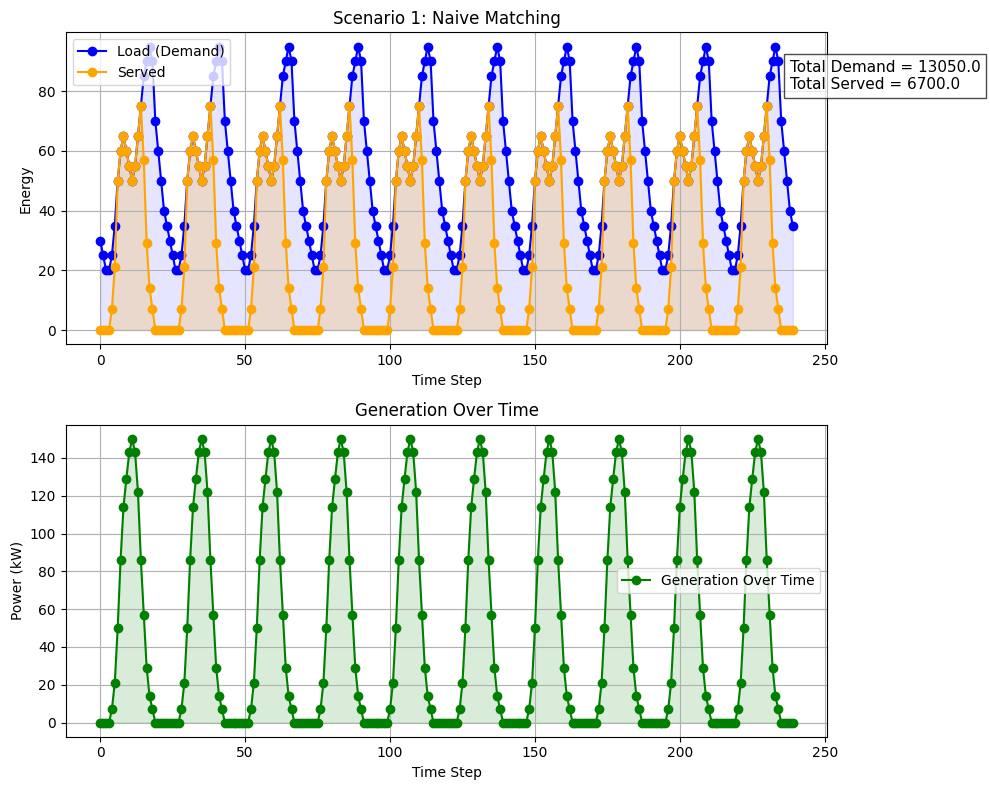

In [14]:
served_1 = [min(L[t], G[t]) for t in range(T)]
plot_results("Scenario 1: Naive Matching", served_1, second_plot=True)


# Scenario 2 — Workload Scheduling without Storage


In this implementation we have a backlog, that is incrementally built and once we have power we chip away at the power. We essentially compute as much load as the generation allows.
Cap in the total allowable computation, for capacity.

Start at 3pm for this example

In [33]:
import gurobipy as gp
from gurobipy import GRB

# print(f"Geneartion {G}, total generation = {sum(G)}")
# print(f"Load {L}, total load = {sum(L)}")

# Model
m2 = gp.Model("workload_scheduling_no_storage")
m2.setParam('OutputFlag', 0)

# Decision variables
u = m2.addVars(T+1, name="u", lb=0)        # Energy used
x = m2.addVars(T+1, name="x", lb=0)      # Backlog

# Initial condition
m2.addConstr(x[0] == 0, "initial_backlog")

# Dynamics and constraints
for t in range(T):
    m2.addConstr(u[t] <= G[t], name=f"generation_limit_{t}")
    m2.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")
    m2.addConstr(u[t] <= computing_limit, name=f"computing limit")

# Terminal condition
m2.addConstr(x[T] >= 0, "terminal_backlog")

# Objective: Minimize backlog and energy cost (incentivizes serving more load)
m2.setObjective(gp.quicksum(r * x[t] + q*u[t] for t in range(T+1)), GRB.MINIMIZE)

# Optimize
m2.optimize()

# Extract and plot results
if m2.status == GRB.OPTIMAL:
    # served_2 = [u[t].X for t in range(T)]
    # backlog_2 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    print("found a solution")
    # plot_results_1("Scenario 2: Workload Scheduling Only", served_2, second_plot=True, backlog=backlog_2)


found a solution


# Scenario 3: Storage, no workload scheduling

Can make the variable of start day and end day of how much storage we have

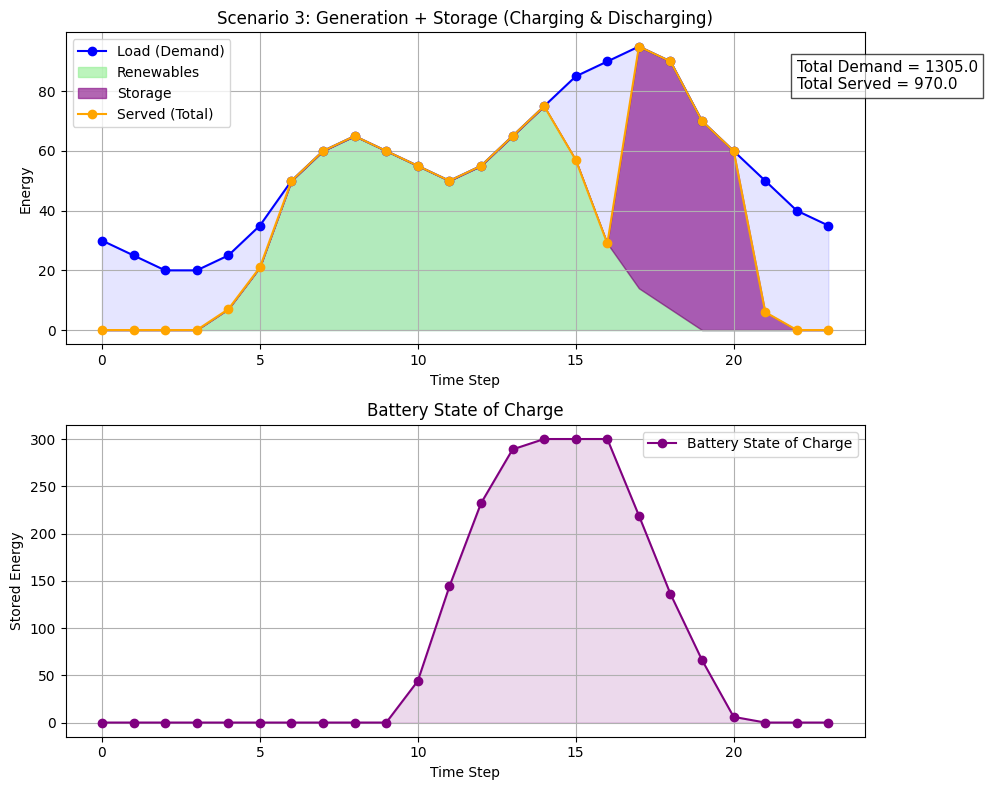

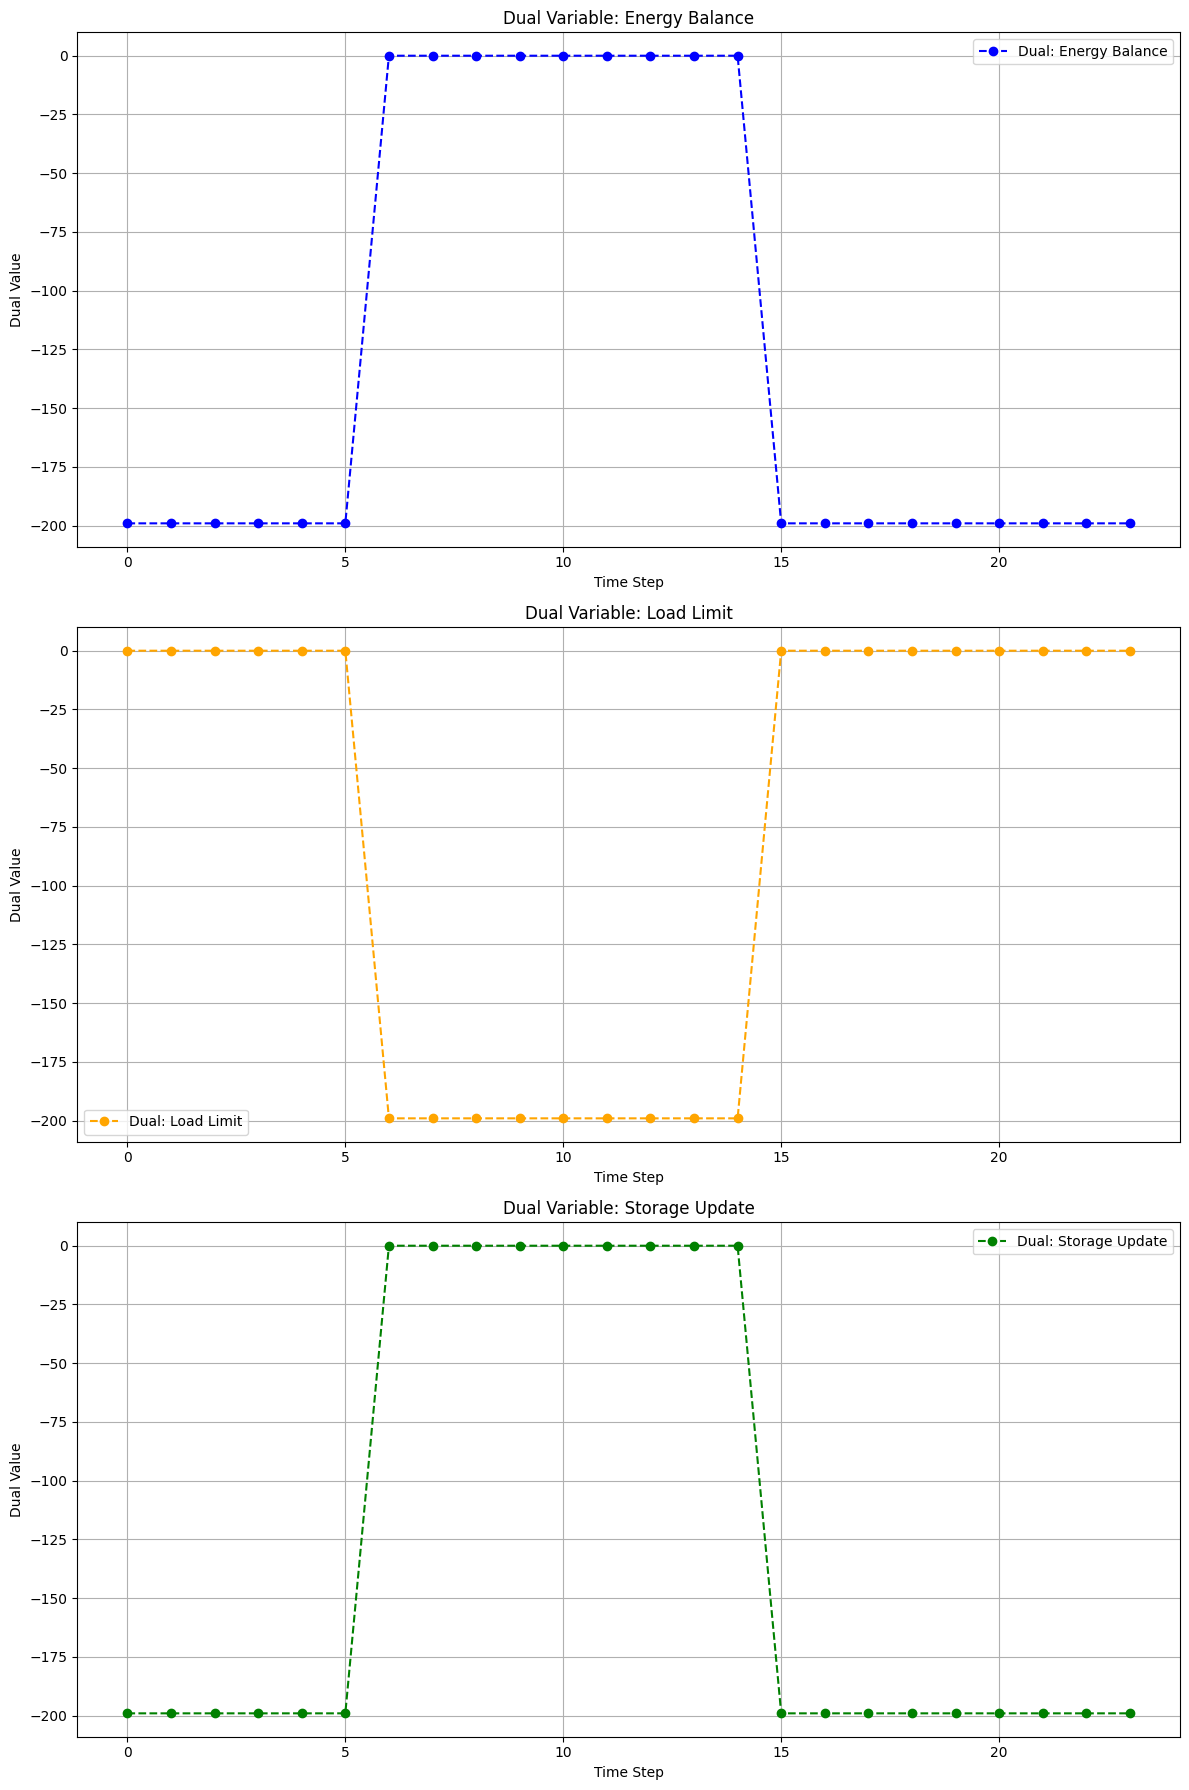

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Given values


# Model
m3 = gp.Model("generation_storage_with_charging_discharging")
m3.setParam('OutputFlag', 0)


# Decision variables
u = m3.addVars(T, name="u", lb=0)              # Energy used to meet load (no negative use)
s_charge = m3.addVars(T, name="s_charge", lb=0)  # Energy charged into the storage
s_discharge = m3.addVars(T, name="s_discharge", lb=0)  # Energy discharged from storage
c = m3.addVars(T+1, name="c", lb=0)             # Battery storage level at each time step

# Initial condition for battery storage
m3.addConstr(c[0] == 0, "initial_storage")

# Constraints
for t in range(T):
    # Energy used to meet load
    m3.addConstr(u[t] <= L[t], name=f"meet_load_{t}")
    
    # Energy balance equation: G[t] = u[t] + s_charge[t] - s_discharge[t]
    m3.addConstr(u[t] + s_charge[t] - s_discharge[t] <= G[t], name=f"energy_balance_{t}")
    
    # Update storage level: c[t+1] = c[t] + s_charge[t] - s_discharge[t]
    m3.addConstr(c[t+1] == c[t] + s_charge[t] - s_discharge[t], name=f"storage_update_{t}")
    m3.addConstr(c[t]<=battery_limit, name = "storage limit")

    m3.addConstr(u[t] <= computing_limit, name=f"computing limit")


# Final condition: the battery should be empty at the end
m3.addConstr(c[T] == 0, "terminal_storage")

# Objective: minimize energy used (serving load) and energy storage transitions (charging/discharging)
m3.setObjective(gp.quicksum(q * u[t] + r * (L[t]-u[t]) for t in range(T)), GRB.MINIMIZE)
#In this case there's no backlog so we simply penalize demand no met

# Optimize
m3.optimize()

if m3.status == GRB.OPTIMAL:
    served_3 = [u[t].X for t in range(T)]
    soc_3 = [c[t].X for t in range(1, T+1)]
    from_storage_3 = [s_discharge[t].X for t in range(T)]
    from_renewables_3 = [served_3[t] - from_storage_3[t] if served_3[t] >= from_storage_3[t] else 0 for t in range(T)]
    
    duals_3 = {
    "Energy Balance": [m3.getConstrByName(f"energy_balance_{t}").Pi for t in range(T)],
    "Load Limit": [m3.getConstrByName(f"meet_load_{t}").Pi for t in range(T)],
    "Storage Update": [m3.getConstrByName(f"storage_update_{t}").Pi for t in range(T)],
    # "Storage Limit": [m3.getConstrByName(f"storage limit").Pi],  # Only one for the storage limit
    # "Computing Limit": [m3.getConstrByName(f"computing limit").Pi],  # Only one for the computing limit
}


    plot_results_1(
        title="Scenario 3: Generation + Storage (Charging & Discharging)",
        served=served_3,
        soc=soc_3,
        from_storage=from_storage_3,
        from_renewables=from_renewables_3,
        duals=duals_3,
    )


Include efficiency terms examine the trade-off between workload scheduling, finding the balance between those cost.

# scenario 4: Workload scheduling + storage

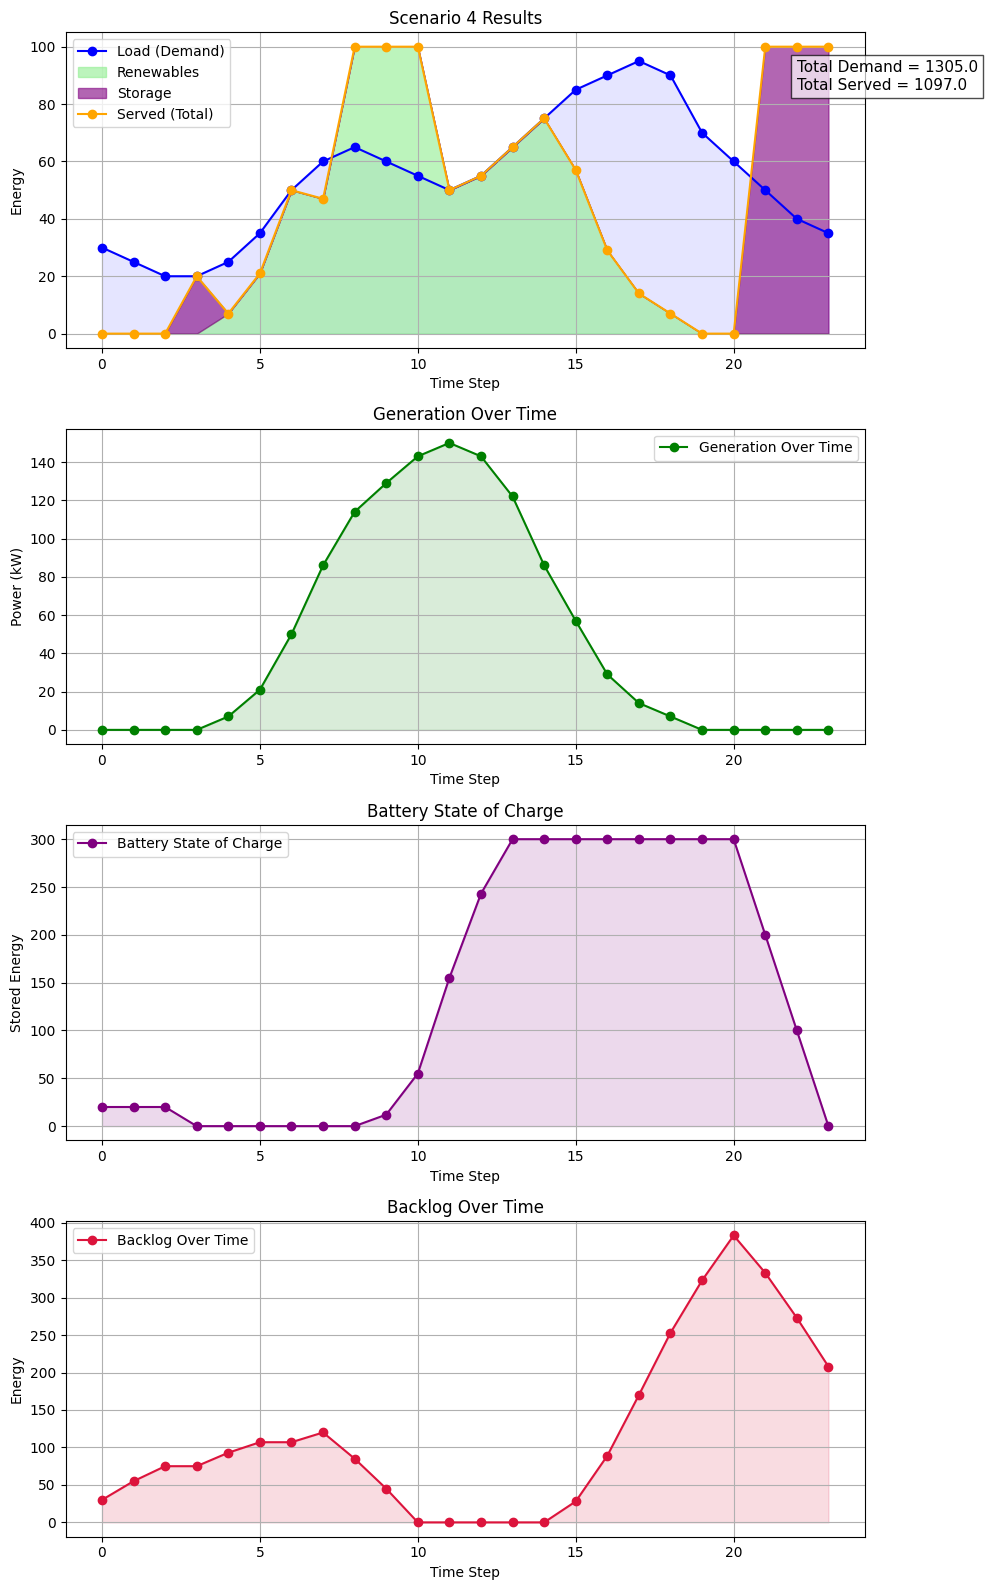

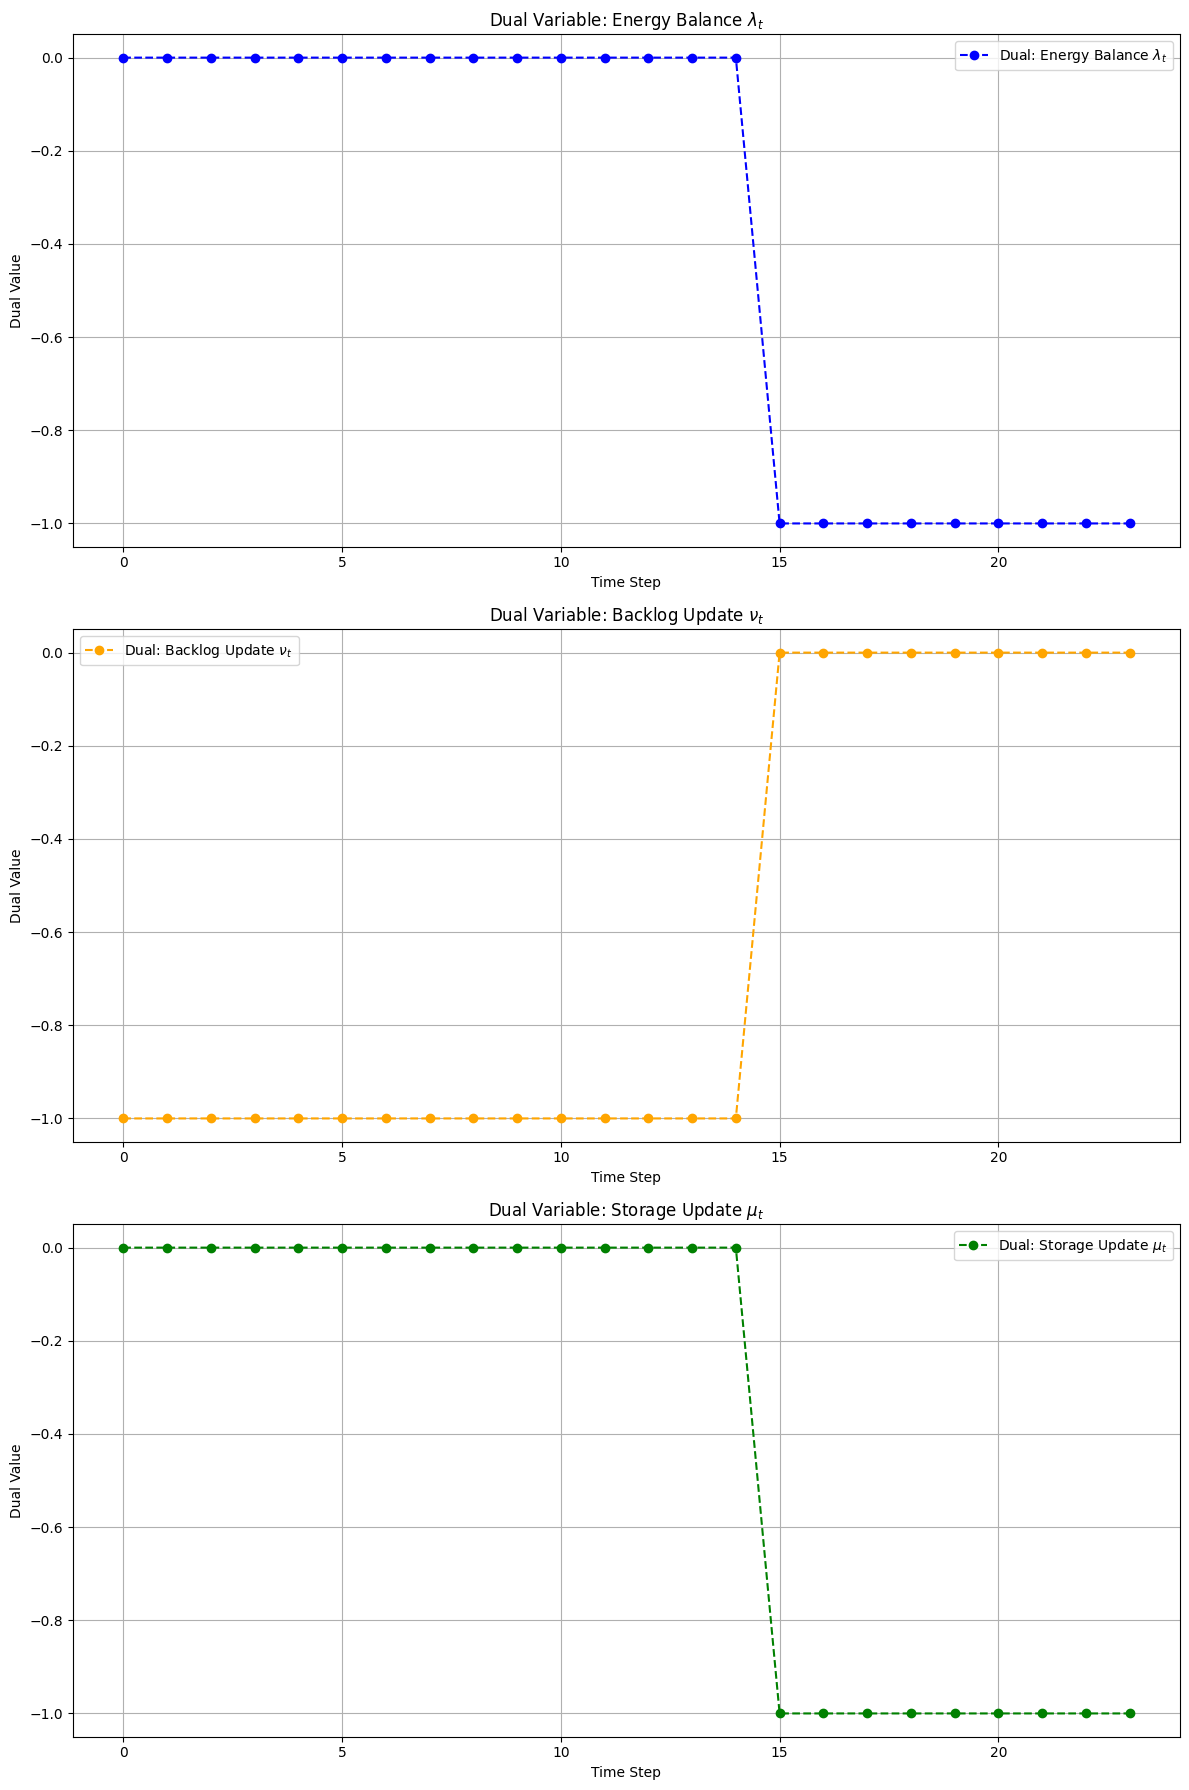

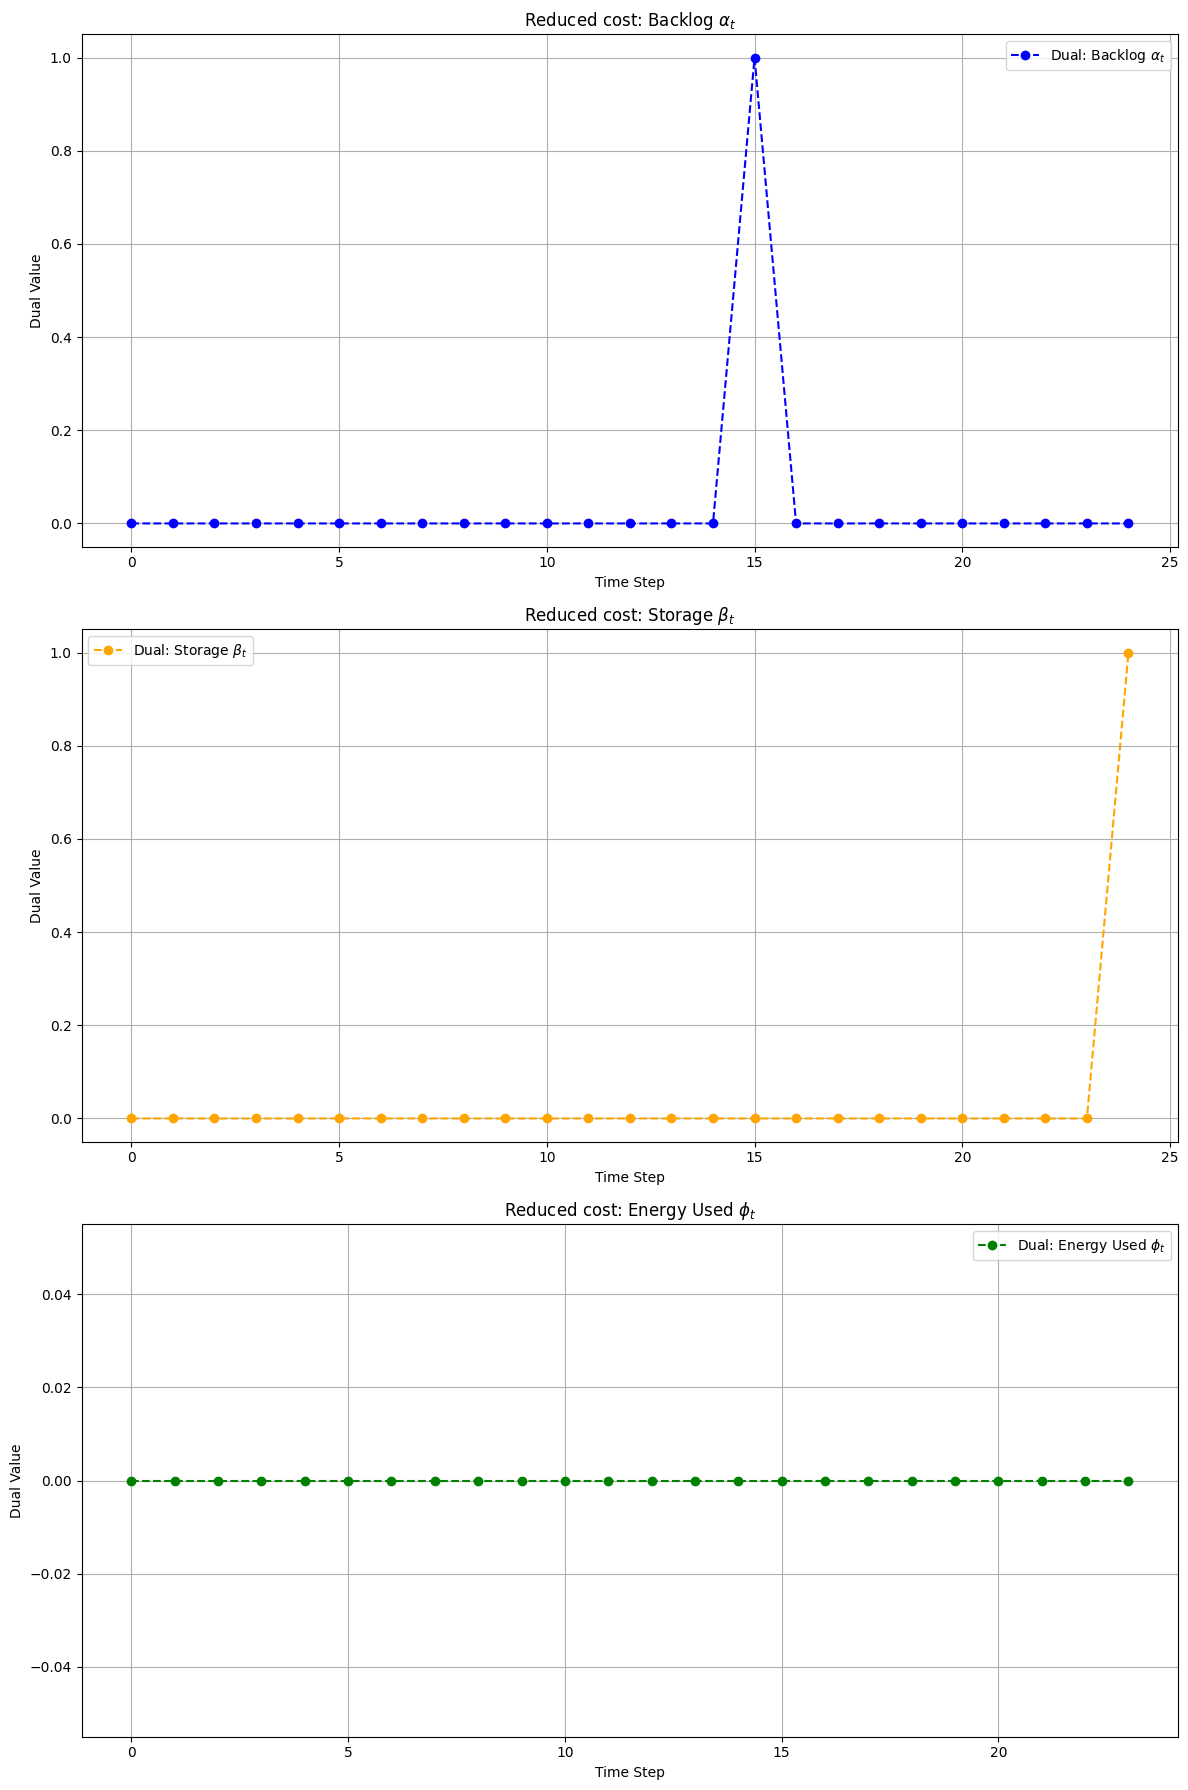

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Model
m4 = gp.Model("workload_storage_scheduling_scenario_4")
m4.setParam('OutputFlag', 0)

# Decision variables
u = m4.addVars(T, name="u", lb=0)              # Energy used to meet load
s_charge = m4.addVars(T, name="s_charge", lb=0)  # Energy charged into storage
s_discharge = m4.addVars(T, name="s_discharge", lb=0)  # Energy discharged from storage
x = m4.addVars(T+1, name="x", lb=0)             # Backlog at each time step
c = m4.addVars(T+1, name="c", lb=0)             # Storage level (state of charge) at each time step

# Initial conditions
m4.addConstr(x[0] == 0, "initial_backlog")
m4.addConstr(c[0] == 0, "initial_storage")

# Dynamics and constraints
for t in range(T):
    # Energy used to meet the load (all load must be met)
    # m4.addConstr(u[t] == L[t], name=f"meet_load_{t}")
    
    # Energy balance equation: G[t] = u[t] + s_charge[t] - s_discharge[t]
    m4.addConstr(u[t] + s_charge[t] - s_discharge[t] <= G[t], name=f"energy_balance_{t}")
    
    # Update storage level: c[t+1] = c[t] + s_charge[t] - s_discharge[t]
    m4.addConstr(c[t+1] == c[t] + s_charge[t] - s_discharge[t], name=f"storage_update_{t}")
    m4.addConstr(c[t]<=battery_limit, name = f"storage limit_{t}")

    
    # Backlog update: x[t+1] = x[t] + L[t] - u[t]
    m4.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")

    m4.addConstr(u[t] <= computing_limit, name=f"computing limit")


# Terminal conditions: no backlog and battery is empty at the end
# m4.addConstr(x[T] == 0, "terminal_backlog")
m4.addConstr(c[T] >= 0, "terminal_storage")

# Objective: minimize energy use (serving load) and energy storage transitions (charging/discharging)
# m4.setObjective(gp.quicksum(q * u[t] + r * x[t] for t in range(T)), GRB.MINIMIZE) # previously had cost to charge and discharged changed to cost ot backlog
m4.setObjective(gp.quicksum(-q * u[t]  for t in range(T)), GRB.MINIMIZE) # previously had cost to charge and discharged changed to cost ot backlog

# punish backlog, unmet demand
# Optimize the model
m4.optimize()

# Print results
if m4.status == GRB.OPTIMAL:
    served = [u[t].X for t in range(T)]
    soc = [c[t].X for t in range(1, T+1)]
    backlog = [x[t].X for t in range(1, T+1)]
    from_storage = [s_discharge[t].X for t in range(T)]
    from_renewables = [served[t] - from_storage[t] if served[t] >= from_storage[t] else 0 for t in range(T)]
    
    duals_energy_balance = []
    duals_soc_update = []
    duals_soc_limit = []
    duals_backlog_update = []

    # Get duals over time
    for t in range(T):
        duals_energy_balance.append(m4.getConstrByName(f"energy_balance_{t}").Pi) #if (cname := f"R{t}") in m4.getConstrs() else m4.getConstrs()[3*t].Pi)
        duals_soc_update.append(m4.getConstrByName(f"storage_update_{t}").Pi)   # constraint: c[t+1] == c[t] + ...
        # duals_soc_limit.append(m4.getConstrs()[3*t + 2].Pi)    # constraint: c[t] <= battery_limit
        duals_backlog_update.append(m4.getConstrByName(f"backlog_update_{t}").Pi) # constraint: x[t+1] = x[t] + ...

    # Terminal duals
    # dual_terminal_backlog = m4.getConstrByName("terminal_backlog").Pi
    dual_terminal_storage = m4.getConstrByName("terminal_storage").Pi

    duals = {
        r"Energy Balance $\lambda_t$": duals_energy_balance,
        r"Backlog Update $\nu_t$": duals_backlog_update,
        r"Storage Update $\mu_t$": duals_soc_update,
        # "Storage Limit": duals_soc_limit,
        # "Terminal Backlog": dual_terminal_backlog,
        # "Terminal Storage": dual_terminal_storage
    }
    rc_x = [x[t].RC for t in range(T+1)]
    rc_c = [c[t].RC for t in range(T+1)]
    rc_u_g = [u[t].RC for t in range(T)]
    # rc_u_r = [u_r[t].RC for t in range(T)]
    reduced_costs_4 = {
        r"Backlog $\alpha_t$": rc_x,
        r"Storage $\beta_t$": rc_c,
        r"Energy Used $\phi_t$": rc_u_g,
        # "Renewable Energy Used": rc_u_r
    }

    plot_results_1(
        title="Scenario 4 Results",
        second_plot=True,
        served=served,
        soc=soc,
        backlog=backlog,
        from_storage=from_storage,
        from_renewables=from_renewables,
        duals=duals,
        reduced_costs=reduced_costs_4,
    )

Deferal of elecrtricity for workload schedule, look for interesting ranges, 
Regime changes, where we switch from storage to workload to storage.
Find an analytical solution
Leave cost of load shifting as a variable,

Cost of load shifting is taken care of backlog, 

Add an innefiency to discahrge c, for analytical solution, once we have everything go through and replace with eta and make it all works. help us the regime shift between load shifting and storage. For computaiton we can leave eta as is, for charge and discharge

From this first pass on the ACDC, we can see numerically that Job scheduling and storage complement each other as hypothesized by result of solving the optimal dual variables: check notes.
Indeed, in scenario 3, where we only had storage, we had to store 488 MW, to serve 1158 MW of load. In scenario 2, where we only schedule jobs, we serve 797 had a final backlog of, 500, the sum of all backlogs at 3435 (area under the curve), and the max backlog 508.
When we combine both we are able to meet the same demand of 1158, max stored amount 361 (-127 MW), and max backlog 330 (-178), total backlog 2249 (-1200?), and final backlog of 150 (-350).
Interestingly enough, if we introduce a maximum computational ability, it doesn't change our results that much.

In both cases, we still can't meet the entire demand, which is surprising to me since total generation surpasses ask in OH, we would need to have a lot more storage and renewable production for that to happen. But we try another alternative, to incorporate the grid.

# Scenario 5 Grid - No Renewables

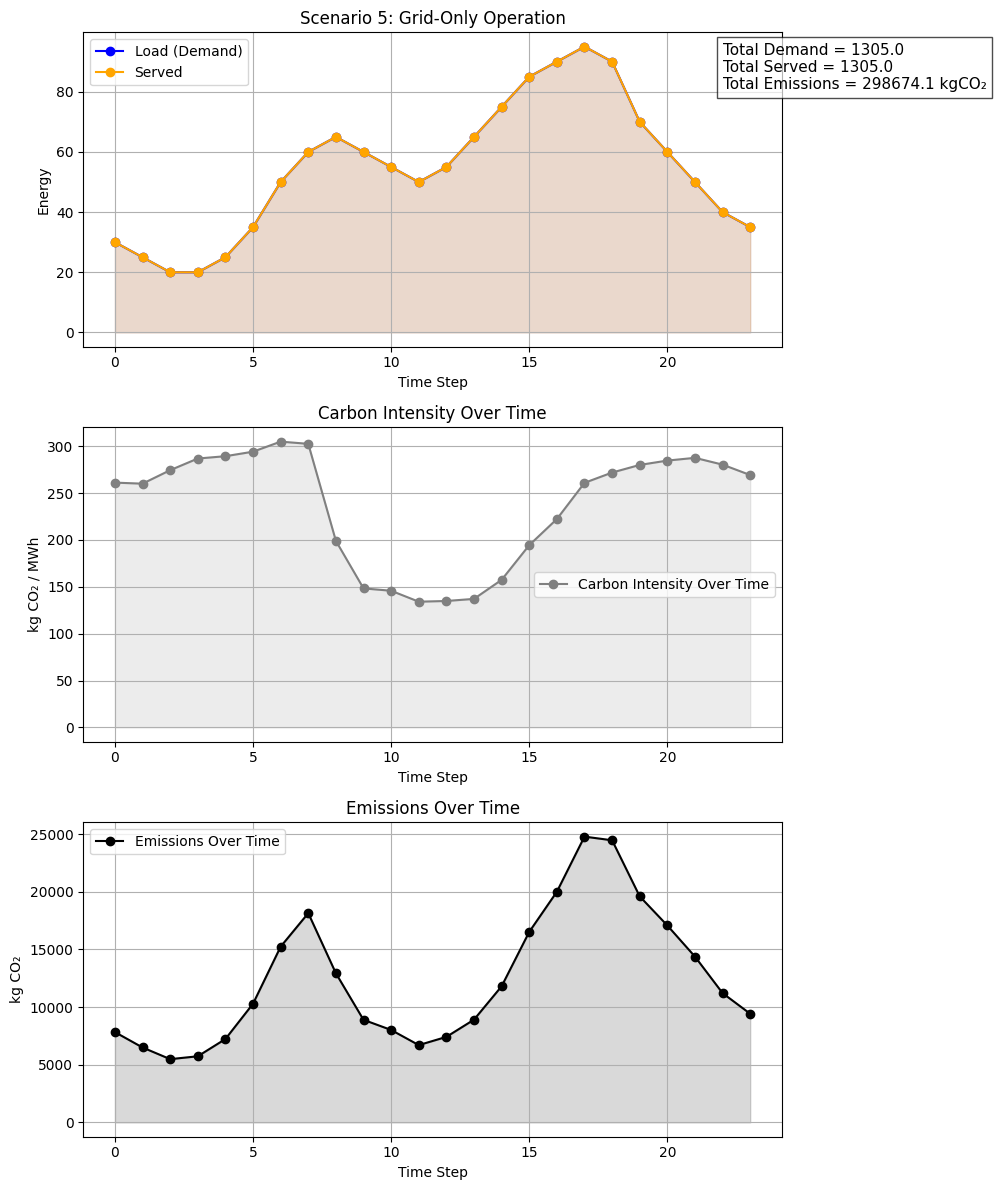

In [ ]:

# Assume all demand is served by the grid
served_5 = L[:]  # copy of L, since all load is met
grid_energy = L  # all demand is met via the grid

# Calculate emissions in kgCO2 (convert gCO2/kWh to kgCO2/kWh)
emissions_5 = [grid_energy[t] * C[t] for t in range(T)]
total_emissions_5 = sum(emissions_5)

# Plot results
plot_results("Scenario 5: Grid-Only Operation", served_5, second_plot=False, carbon_intensity=C,emissions=emissions_5)




# Scenario 6 Grid + JS 

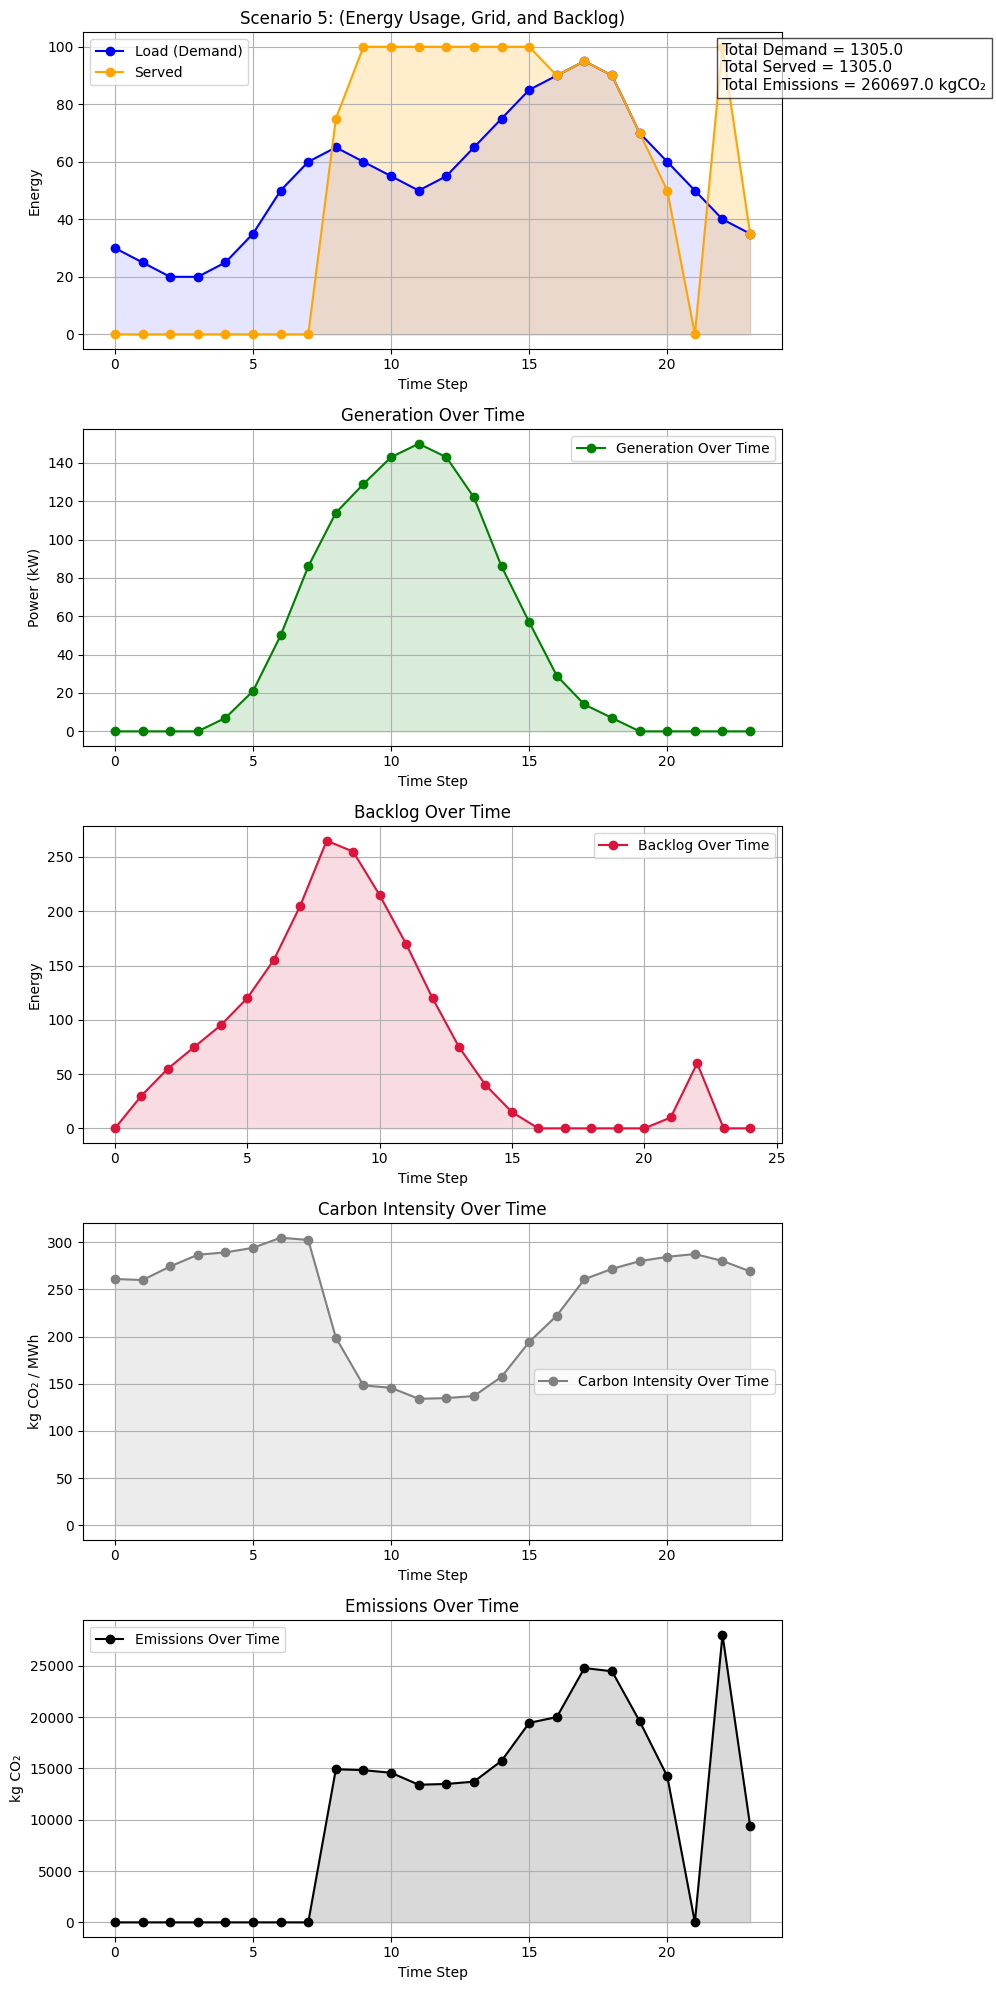

In [ ]:
m5 = gp.Model("Grid optimal Scheduling")
m5.setParam("OutputFlag",0)

# Decision Variables
u = m5.addVars(T,name = "u",lb=0) #u_T computing at time t
x = m5.addVars(T+1,name="x",lb=0) # backlog
# Initial Conditions
m5.addConstr(x[t] ==0,"initial backlog")

for t in range(T):
    m5.addConstr(x[t+1] == x[t]+L[t] - u[t])
    m5.addConstr(u[t] <= computing_limit)

m5.addConstr(x[T] ==0,"terminal backlog") #ensure that all the demand is met

m5.setObjective(gp.quicksum(u[t]*C[t] for t in range(T)),GRB.MINIMIZE)

m5.optimize()

if m5.status == GRB.OPTIMAL:
    served_5 = [u[t].X for t in range(T)]  # Energy served to meet the load
    backlog_5 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_5 = [u[t].X * C[t] for t in range(T)]
    plot_results("Scenario 5: (Energy Usage, Grid, and Backlog)", served_5,second_plot=True, backlog = backlog_5, carbon_intensity=C,emissions= emissions_5)


Add the Social cost of carbon, 50 dollars per ton, cost of electricity (static of dynamic)

# Scenario 7 Grid, Storage, JS, Renewables


Optimal Schedule for Integrated Model:


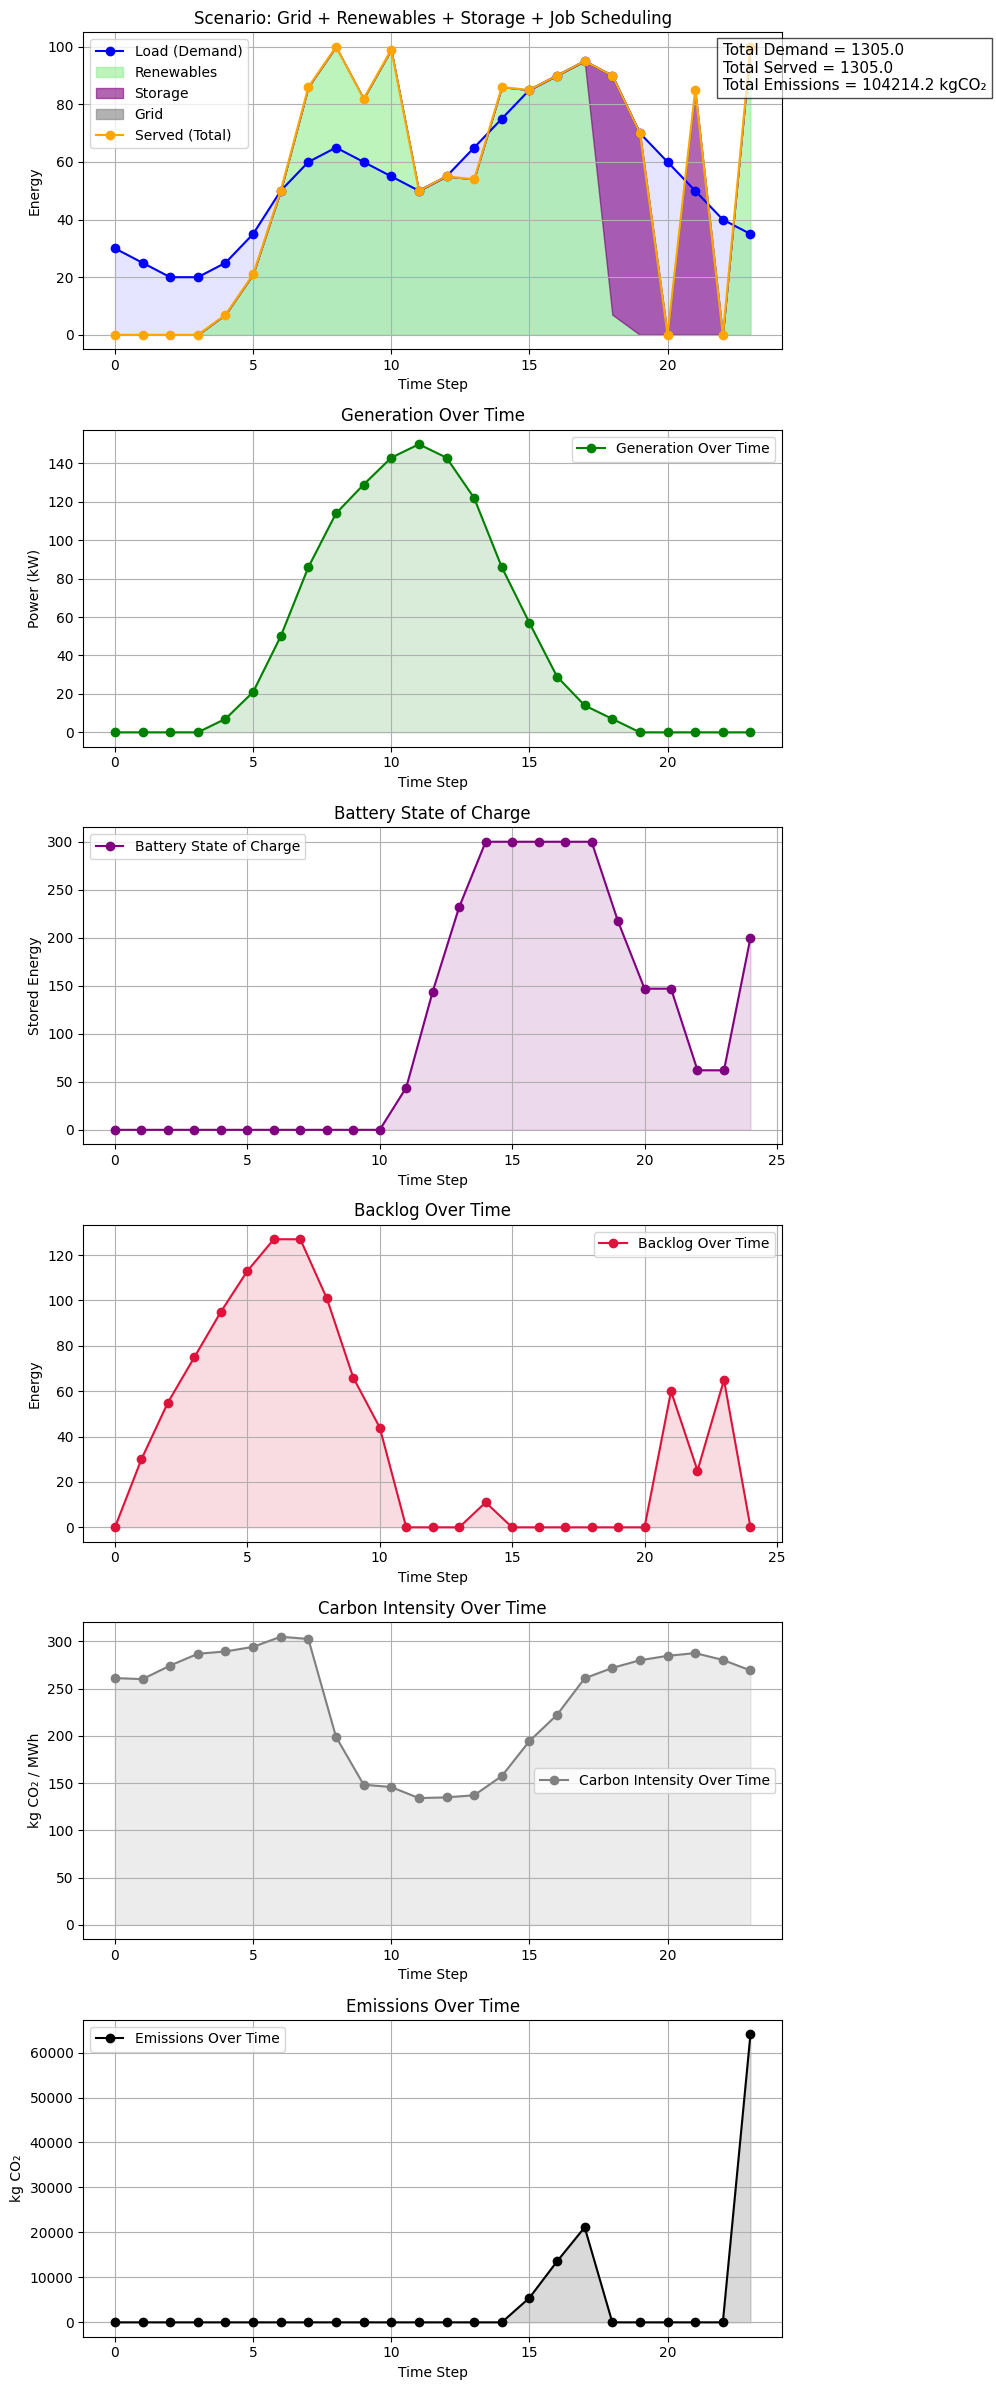

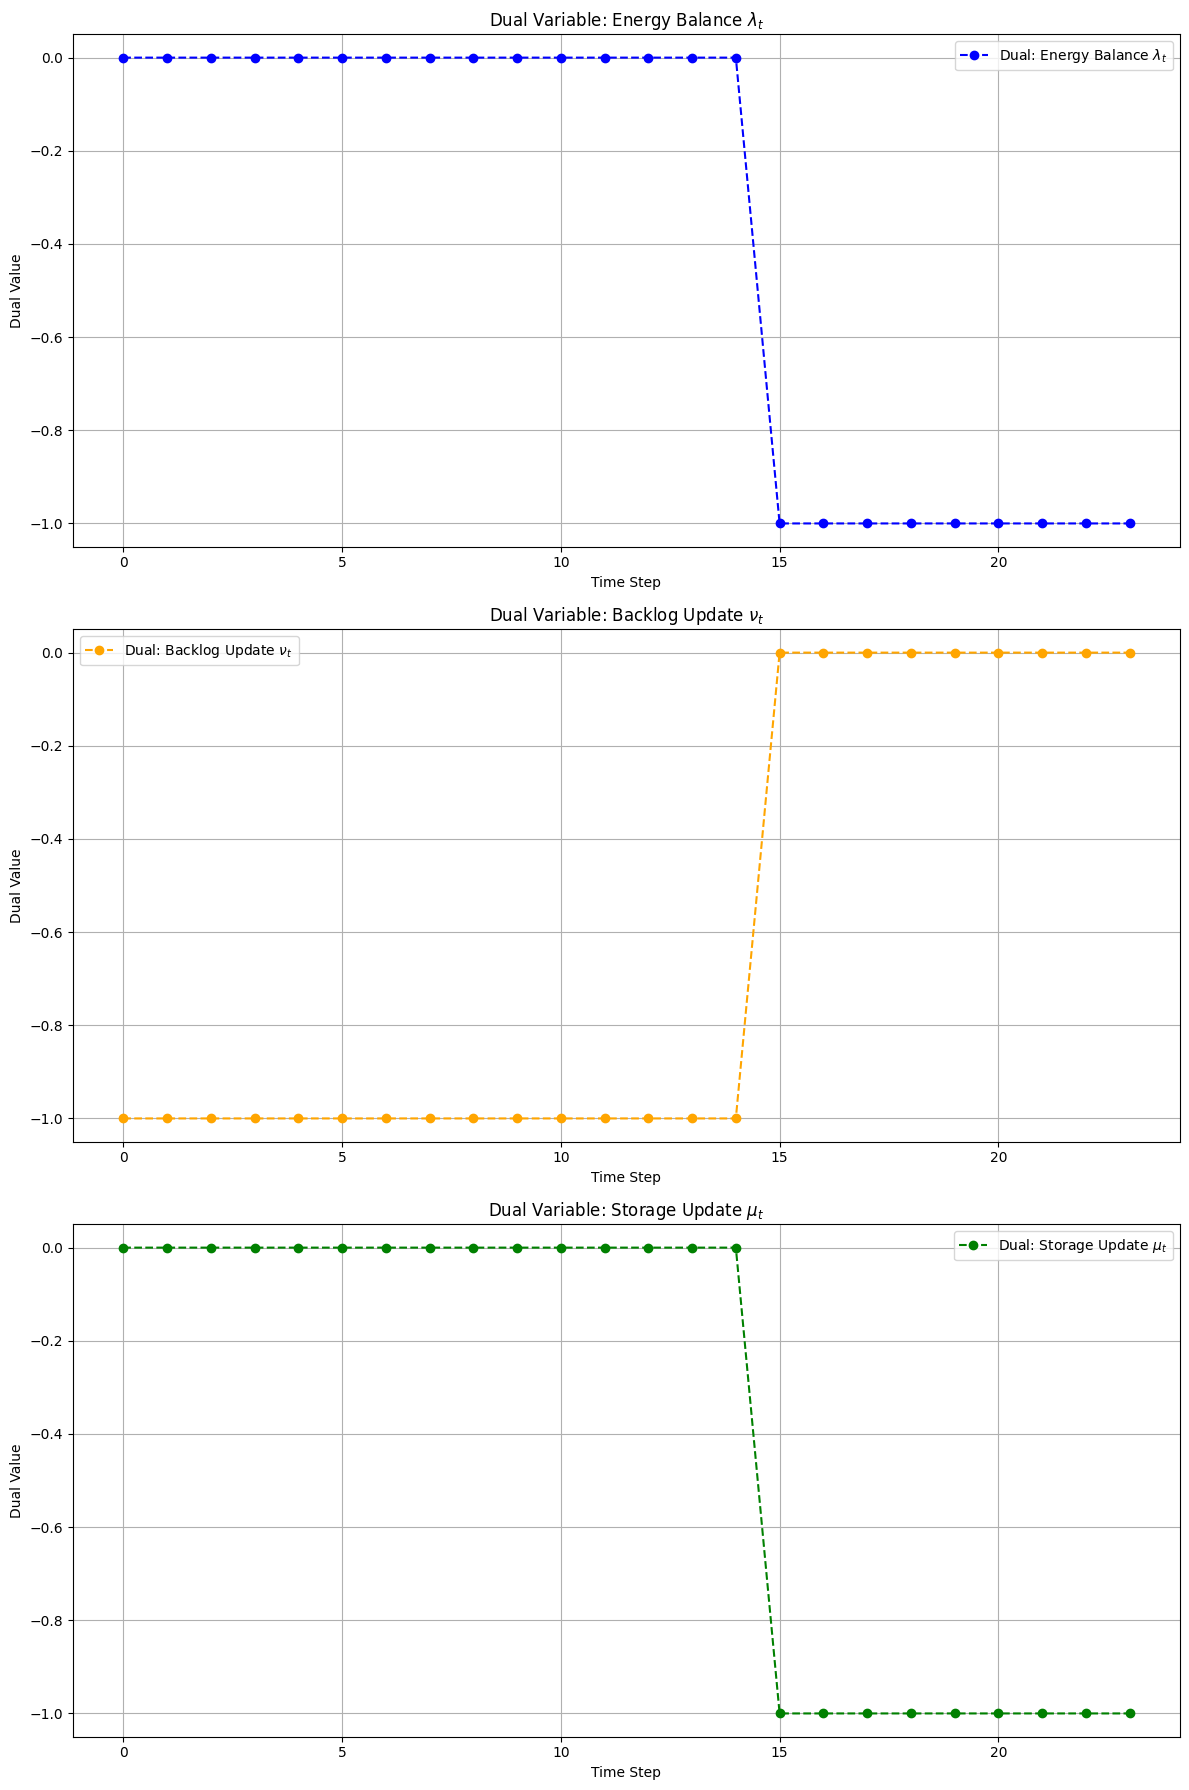

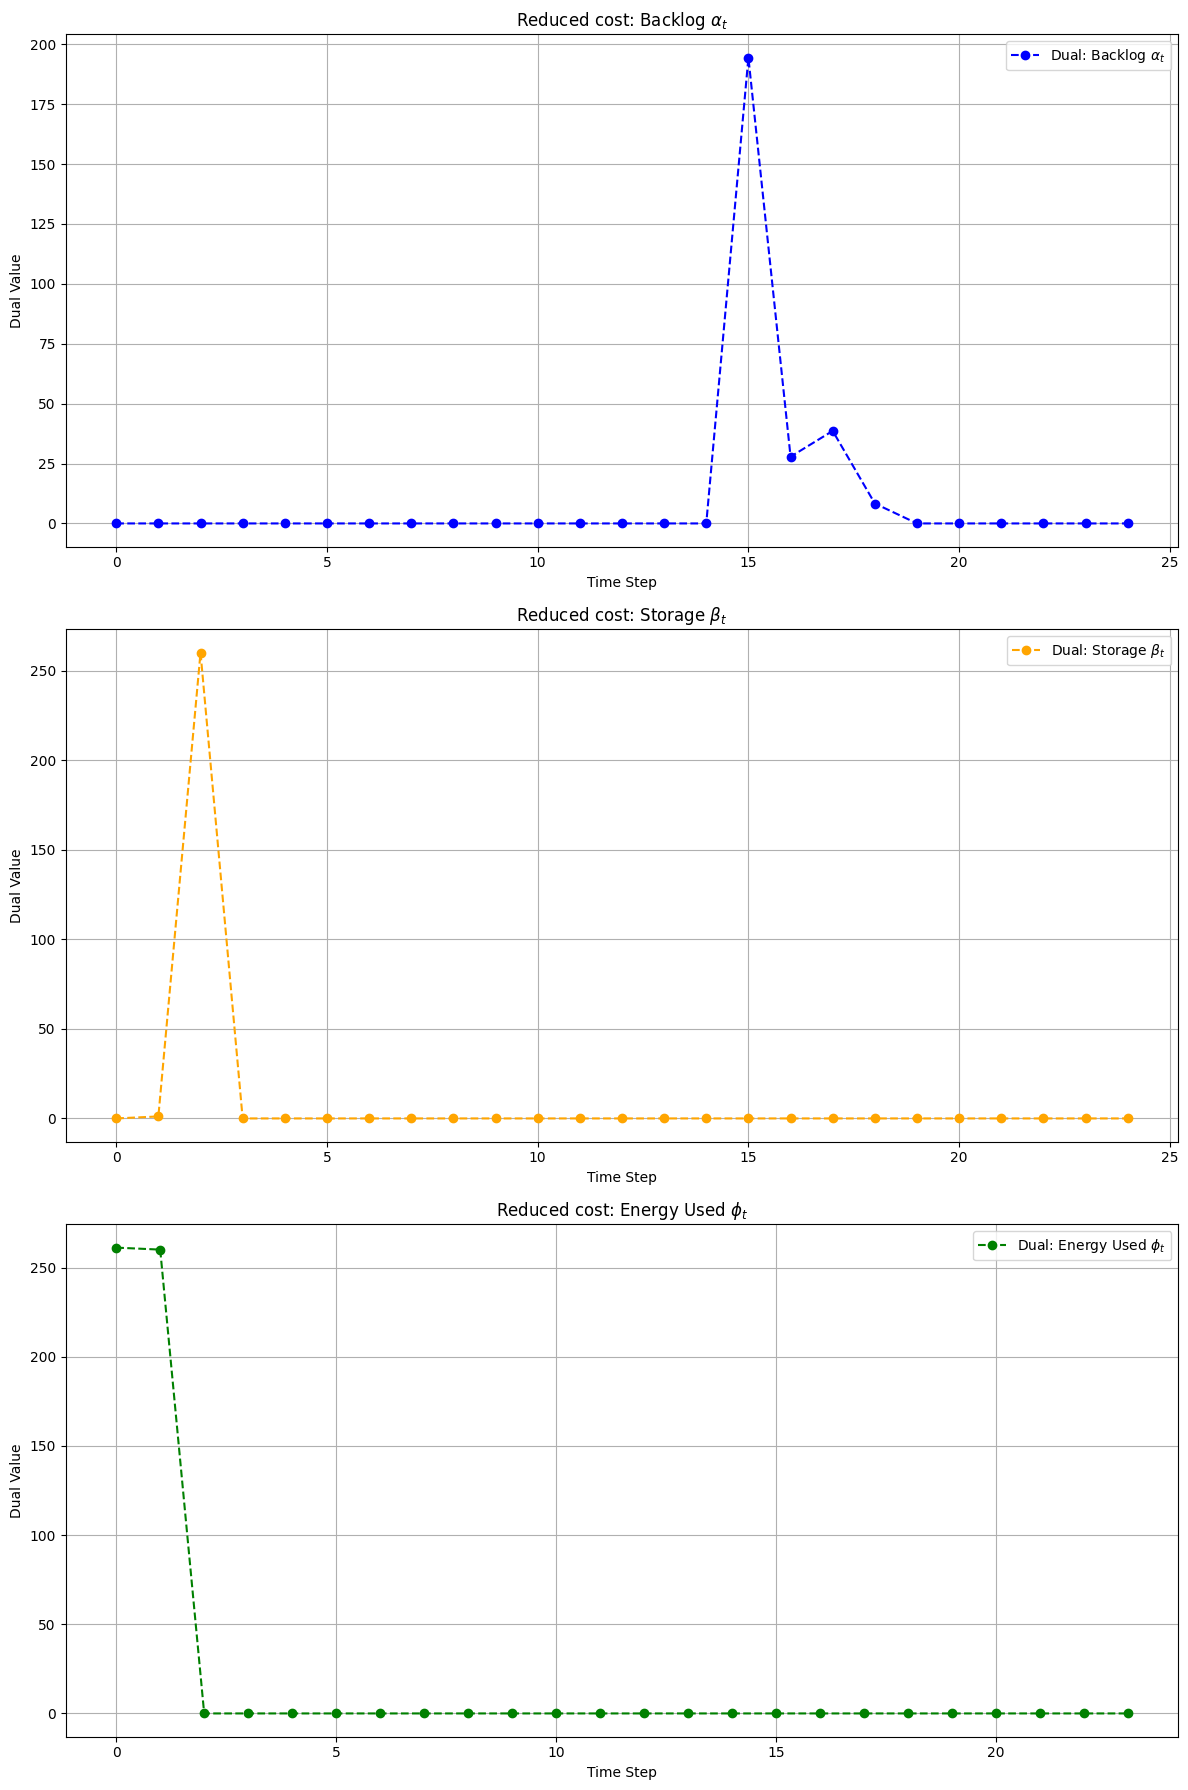

In [ ]:
m_7 = gp.Model("Grid + Storage + Renewables Optimal Scheduling")
m_7.setParam("OutputFlag", 0)

# Variables
u_g_7 = m_7.addVars(T, name="u_g_7", lb=0)  # Grid usage
u_r_7 = m_7.addVars(T, name="u_r_7", lb=0)  # Renewable usage
s_charge_r = m_7.addVars(T, name="s_charge_r", lb=0)  # Charging from renewables
s_charge_g = m_7.addVars(T, name="s_charge_g", lb=0)  # Charging from grid
s_discharge = m_7.addVars(T, name="s_discharge", lb=0)  # Battery discharge
x = m_7.addVars(T+1, name="x", lb=0)  # Backlog
c = m_7.addVars(T+1, name="c", lb=0)  # Storage SoC
u = m_7.addVars(T, name="u", lb=0)  # Energy served to meet load

# Initial conditions
m_7.addConstr(x[0] == 0, "initial_backlog")
m_7.addConstr(c[0] == 0, "initial_storage")

# Terminal conditions
m_7.addConstr(c[T] >= 200, "terminal_storage")  # optional: keep some energy left
m_7.addConstr(x[T] <= x[0], "terminal_backlog")  # prefer serving all load

# Constraints
m_7.addConstrs((c[t+1] == c[t] + s_charge_r[t] + s_charge_g[t] - s_discharge[t] for t in range(T)), name="soc_update")
m_7.addConstrs((c[t+1] <= battery_limit for t in range(T)), name="storage_capacity")
m_7.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name="max_discharge")
m_7.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m_7.addConstrs((u[t] <= computing_limit for t in range(T)), name="compute_limit")
m_7.addConstrs((u_r_7[t] + s_charge_r[t] <= G[t] for t in range(T)), name="renewables_limit")
m_7.addConstrs((u_g_7[t] + u_r_7[t] + s_discharge[t] == u[t] + s_charge_r[t] + s_charge_g[t] for t in range(T)), name="energy_balance")

# Objective: minimize grid emissions + backlog
m_7.setObjective(gp.quicksum(u_g_7[t] * C[t] for t in range(T)), GRB.MINIMIZE)

# Optimize
m_7.optimize()

# Results
if m_7.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Integrated Model:")
    served = [u[t].X for t in range(T)]
    soc = [c[t].X for t in range(T+1)]
    backlog = [x[t].X for t in range(T+1)]
    emissions = [u_g_7[t].X * C[t] for t in range(T)]
    from_storage = [s_discharge[t].X for t in range(T)]
    from_renewables = [served[t] - from_storage[t] if served[t] >= from_storage[t] else 0 for t in range(T)]
    from_grid = [served[t] - from_renewables[t] - from_storage[t] for t in range(T)]


    duals_energy_balance = []
    duals_soc_update = []
    duals_soc_limit = []
    duals_backlog_update = []

    # Get duals over time
    for t in range(T):
        duals_energy_balance.append(m4.getConstrByName(f"energy_balance_{t}").Pi) #if (cname := f"R{t}") in m4.getConstrs() else m4.getConstrs()[3*t].Pi)
        duals_soc_update.append(m4.getConstrByName(f"storage_update_{t}").Pi)   # constraint: c[t+1] == c[t] + ...
        # duals_soc_limit.append(m4.getConstrs()[3*t + 2].Pi)    # constraint: c[t] <= battery_limit
        duals_backlog_update.append(m4.getConstrByName(f"backlog_update_{t}").Pi) # constraint: x[t+1] = x[t] + ...

    # Terminal duals
    # dual_terminal_backlog = m4.getConstrByName("terminal_backlog").Pi
    dual_terminal_storage = m4.getConstrByName("terminal_storage").Pi

    duals = {
        r"Energy Balance $\lambda_t$": duals_energy_balance,
        r"Backlog Update $\nu_t$": duals_backlog_update,
        r"Storage Update $\mu_t$": duals_soc_update,
        # "Storage Limit": duals_soc_limit,
        # "Terminal Backlog": dual_terminal_backlog,
        # "Terminal Storage": dual_terminal_storage
    }
    rc_x = [x[t].RC for t in range(T+1)]
    rc_c = [c[t].RC for t in range(T+1)]
    rc_u_g = [u[t].RC for t in range(T)]
    # rc_u_r = [u_r[t].RC for t in range(T)]
    reduced_costs_4 = {
        r"Backlog $\alpha_t$": rc_x,
        r"Storage $\beta_t$": rc_c,
        r"Energy Used $\phi_t$": rc_u_g,
        # "Renewable Energy Used": rc_u_r
    }
    # Plotting results
    plot_results_1("Scenario: Grid + Renewables + Storage + Job Scheduling", served, soc=soc,
                 second_plot=True, backlog=backlog, carbon_intensity=C, emissions=emissions, 
                 from_renewables=from_renewables, from_storage=from_storage, from_grid=from_grid,
                 duals=duals, reduced_costs=reduced_costs_4)





Although we were able to meet all of the demand, perhaps we would have been able to reduce costs further 

# Scenario 8  Cooling and normal generation

We assume that all electricity used for computing purposes is generated into heat, and the heat removed/cooled is the same as the heat generated:

$$
\dot{Q}_{load} = \dot{W}_{computing} = \dot{Q}_{cooling}
$$

Thus, 
$$
P_{chiller}(t) = \frac{\dot{Q}_{cooling}(t)}{COP(T_{ambient}(t))}
$$

From literature (Yu 2005 and Zhang 2024), we determine a relationship between COP and ambient temperature:
$$
COP(T_{ambient}(t)) = COP_{ref} \cdot (1-0.02(T_{ambient} - T_{ref}))
$$

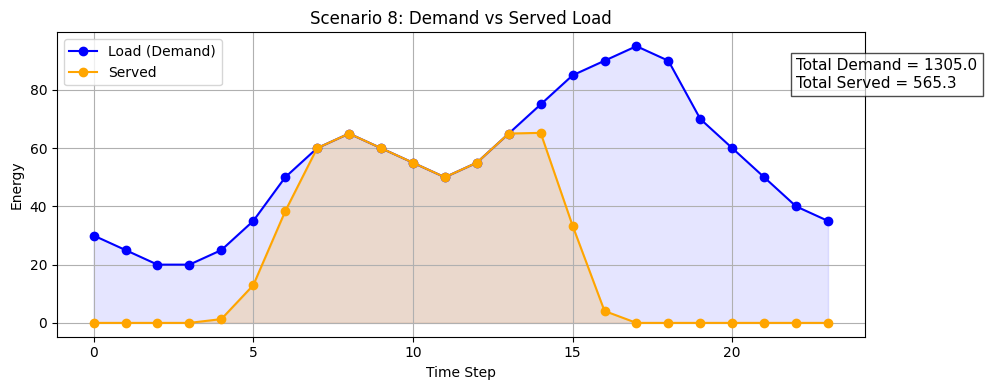

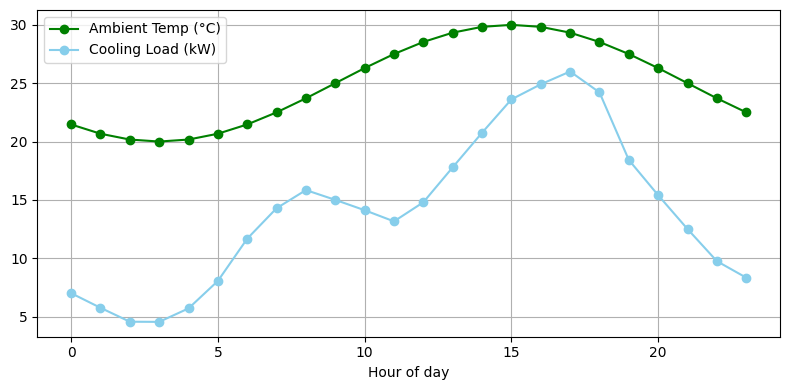

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


hours = np.arange(len(L))
T = len(L)
T_ref, COP_ref = 25.0, 4.0
T_amb = T_ref + 5.0 * np.cos((hours - 15)/24 * 2*np.pi)
COP = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

# 2) cooling electric draw (kW)
P_chiller = L / COP

net_gen = G - P_chiller

# correct served load (list comprehension)
served_8 = [min(L[t], net_gen[t]) for t in range(T)]

# — or, even better, use numpy:
served_8 = np.minimum(L, np.clip(net_gen, 0, None))


# 3) total load served = IT + cooling
served_8  = np.minimum(L, np.clip(net_gen, 0, None))


# Demand vs. Served Load
plot_results("Scenario 8: Demand vs Served Load", served_8)

# Ambient Temperature and Cooling Load
plt.figure(figsize=(8,4))
plt.plot(range(len(L)), T_amb,       marker='o', label="Ambient Temp (°C)", color="green")
plt.plot(range(len(L)), P_chiller,   marker='o', label="Cooling Load (kW)", color="skyblue")
plt.xlabel("Hour of day")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()






# Scenario 9 Cooling and JS

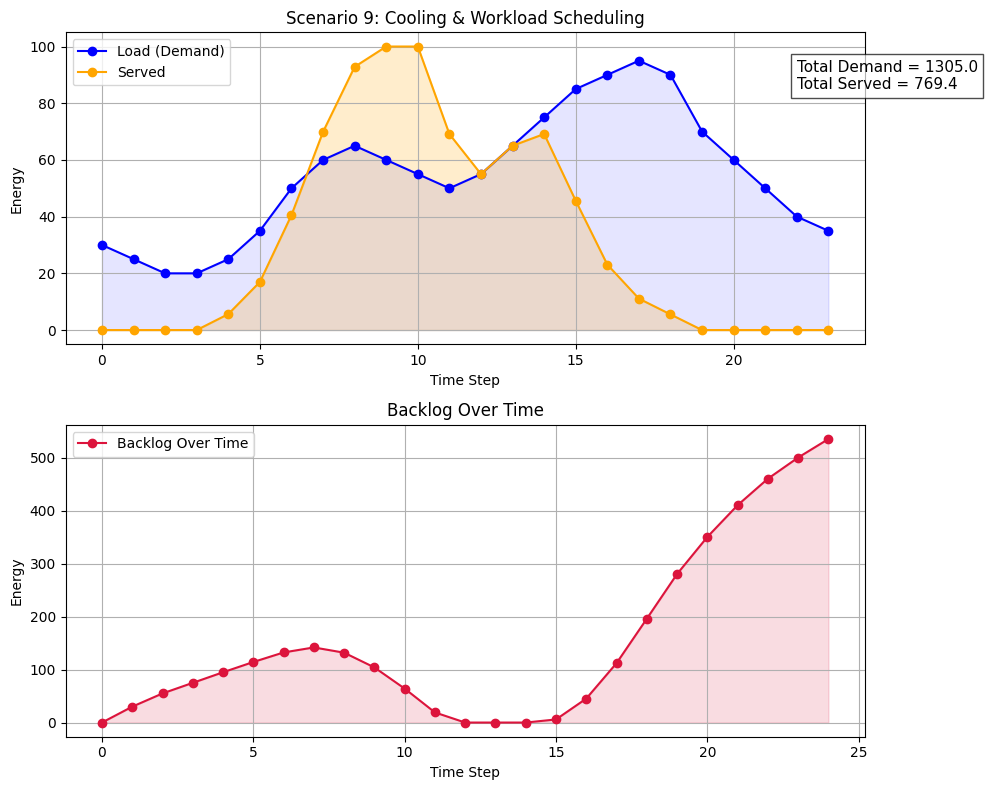

In [ ]:
hours = np.arange(T)             
T_ref, COP_ref = 25.0, 4.0
T_amb = T_ref + 5.0 * np.sin((hours - 15)/24 * 2*np.pi)
COP   = COP_ref * (1.0 - 0.02 * (T_amb - T_ref))

# Model
m9 = gp.Model("cooling_workload_scheduling_no_storage")
m9.setParam('OutputFlag', 0)

# Decision variables
u = m9.addVars(T, name="u", lb=0)        # Computing energy used
x = m9.addVars(T+1, name="x", lb=0)      # Backlog
P_chiller = m9.addVars(hours, lb=0, name="P_chiller")

# Initial condition
m9.addConstr(x[0] == 0, "initial_backlog")

# Dynamics and constraints
for t in range(T):
    m9.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")
    m9.addConstr(u[t] <= computing_limit, name=f"computing limit")
    m9.addConstr((u[t] + P_chiller[t] <= G[t]), name=f"power_balance_{t}")
    m9.addConstr((COP[t] * P_chiller[t] >= u[t]), name=f"cooling_req_{t}")


# Terminal condition
m9.addConstr(x[T] >= 0, "terminal_backlog")

# Objective: Minimize backlog and energy cost (no energy term bc only renewables)
m9.setObjective(gp.quicksum(r * x[t] for t in range(T+1)), GRB.MINIMIZE)

# Optimize
m9.optimize()

# Extract and plot results
if m9.status == GRB.OPTIMAL:
    served_9 = [u[t].X for t in range(T)]
    backlog_9 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    plot_results("Scenario 9: Cooling & Workload Scheduling", served_9, second_plot=None, backlog=backlog_9)
    
if m9.status != GRB.OPTIMAL:
    print("Optimization failed or was not optimal.")



# Scenario 10 Cooling, JS, Storage


Optimal Schedule for Scenario 4:


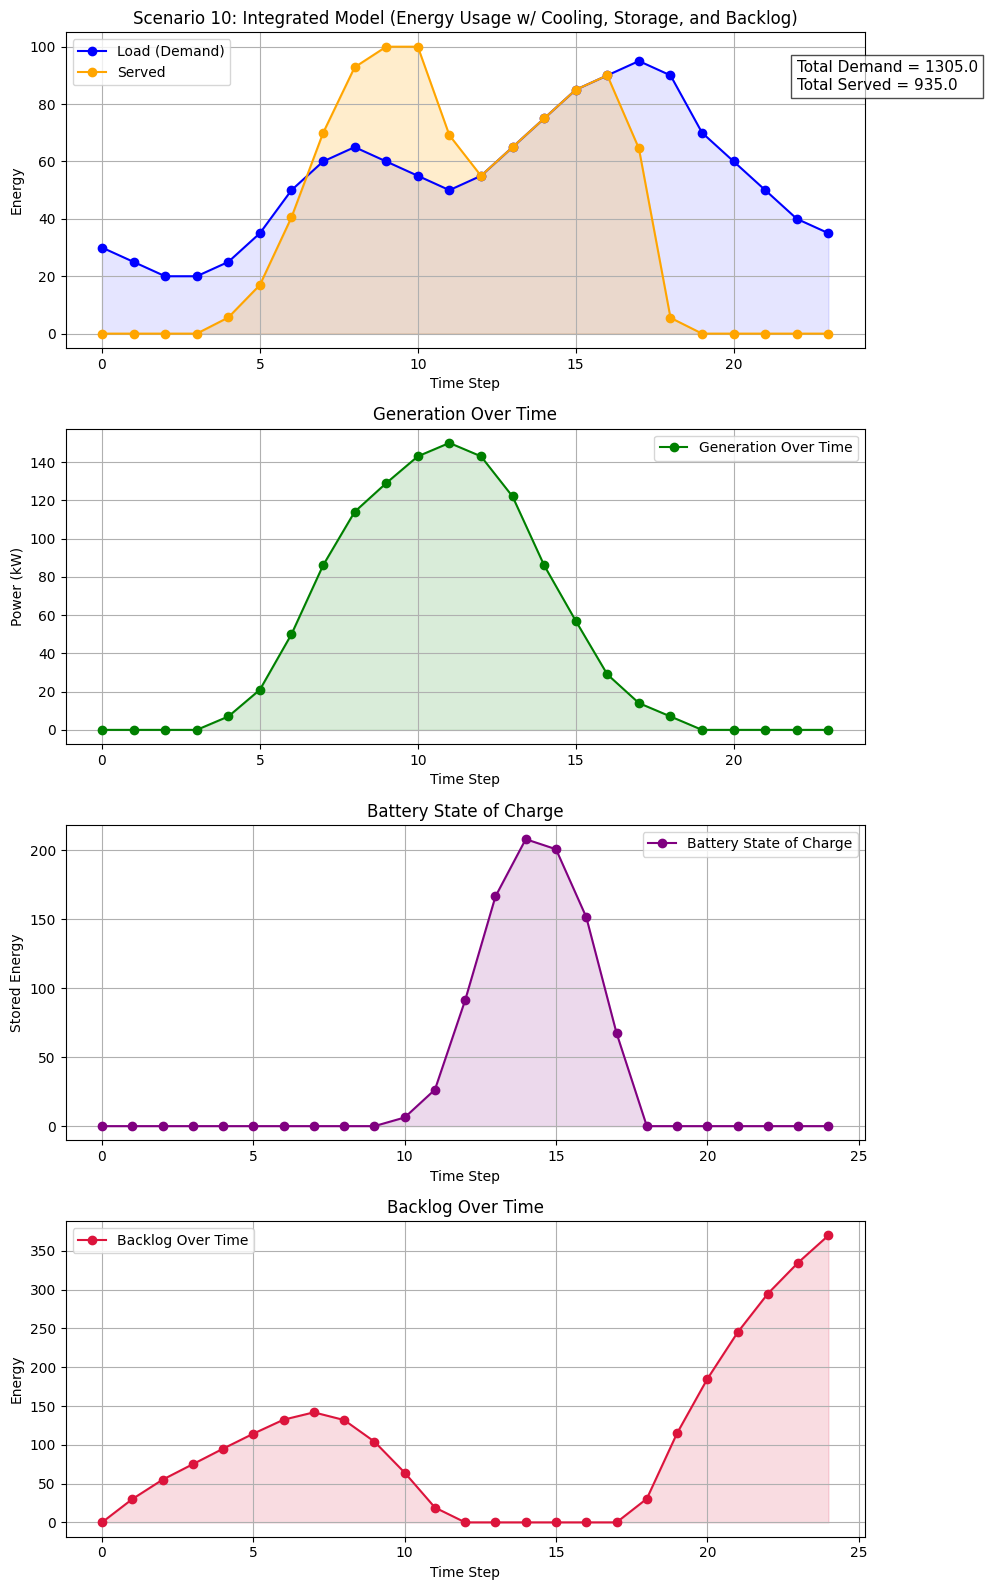

In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Model
m10 = gp.Model("workload_storage_scheduling_scenario_4")
m10.setParam('OutputFlag', 0)

# Decision variables
u = m10.addVars(T, name="u", lb=0)              # Energy used to meet load
s_charge = m10.addVars(T, name="s_charge", lb=0)  # Energy charged into storage
s_discharge = m10.addVars(T, name="s_discharge", lb=0)  # Energy discharged from storage
x = m10.addVars(T+1, name="x", lb=0)             # Backlog at each time step
c = m10.addVars(T+1, name="c", lb=0)             # Storage level (state of charge) at each time step
P_chiller = m10.addVars(T, lb=0, name="P_chiller")

# Initial conditions
m10.addConstr(x[0] == 0, "initial_backlog")
m10.addConstr(c[0] == 0, "initial_storage")

# Dynamics and constraints
for t in range(T):
    
    m10.addConstr(u[t] + P_chiller[t] + s_charge[t] - s_discharge[t] <= G[t], name=f"energy_balance_{t}")
    m10.addConstr(c[t+1] == c[t] + s_charge[t] - s_discharge[t], name=f"storage_update_{t}")
    m10.addConstr(c[t]<=battery_limit, name = "storage limit")
    m10.addConstr(x[t+1] == x[t] + L[t] - u[t], name=f"backlog_update_{t}")
    m10.addConstr(u[t] <= computing_limit, name=f"computing limit")
    m10.addConstr((COP[t] * P_chiller[t] >= u[t]), name=f"cooling_req_{t}")


# Terminal conditions: no backlog and battery is empty at the end
m10.addConstr(c[T] == 0, "terminal_storage")

# Objective: minimize energy use (serving load) and energy storage transitions (charging/discharging)
m10.setObjective(gp.quicksum(q * u[t] + r * (x[t]+L[t]-u[t]) for t in range(T)), GRB.MINIMIZE) # previously had cost to charge and discharged changed to cost ot backlog

# punish backlog, unmet demand
# Optimize the model
m10.optimize()

# Print results
if m10.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 4:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    # Optionally, you can also plot the results
    served_10 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_10 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_10 = [x[t].X for t in range(T+1)]  # Backlog at each time step

    plot_results("Scenario 10: Integrated Model (Energy Usage w/ Cooling, Storage, and Backlog)", served_10, soc=soc_10, second_plot=True,backlog = backlog_10)


# Scenario 11 Grid + Cooling + Storage + JS 

Draw from the grid at noon (or other low carbon intensity times) to compute stuff, store energy at the same time. Then at night, discharge and compute, while ambient temperature is low, and carbon grid intensity is higher. Backlog tasks need to start at the same point and end at the same point.


Optimal Schedule for Scenario 11:


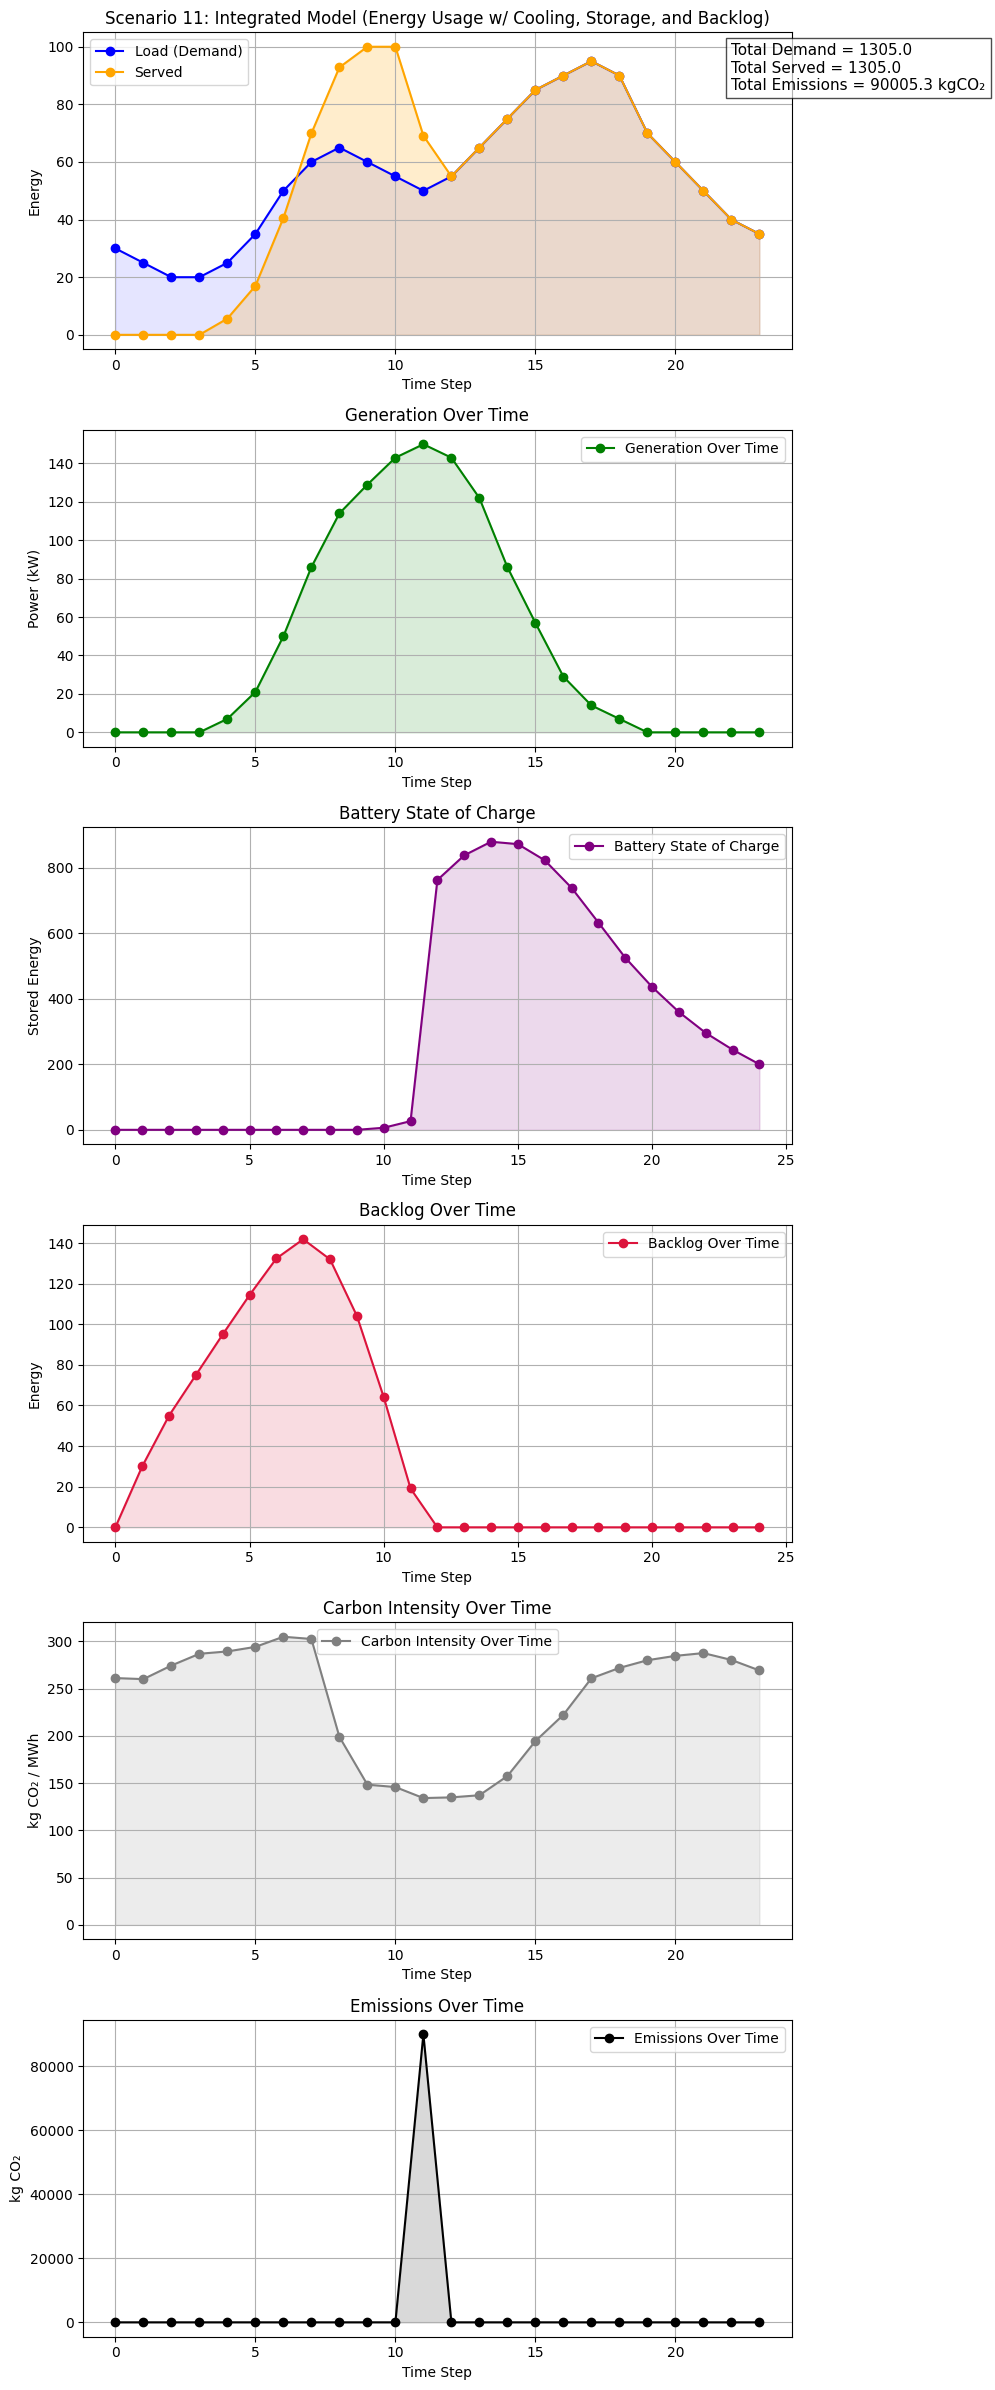

In [ ]:
# Parameters
q = 1.0  # Cost per unit energy used
r =1  # Cost per unit backlog
k = 1  # Storage energy conversion factor
computing_limit = 100 # float("inf") #or switch to actual computing limit
battery_limit = 1000 # float("inf") # or switch to actual computing limit
# Generation (G_t) over 10 time steps (e.g., hours of the day)
# G = [30, 40, 50, 60, 75, 90, 100, 80, 60, 40]  # Peak generation occurs midday and early evening

# # Load (L_t) over the same 10 time steps
# L = [35, 45, 50, 55, 70, 85, 90, 80, 65, 40]  # Load peaks during evening hours
L = [
    30, 25, 20, 20, 25, 35, 50, 60, 65, 60, 55, 50, 
    55, 65, 75, 85, 90, 95, 90, 70, 60, 50, 40, 35
]  # Computational Load sum = 1400
G = [
     0, 0, 0, 0, 7, 21, 50, 86, 114, 129, 143, 150,
   143, 122, 86, 57, 29, 14, 7, 0, 0, 0, 0, 0
]  #Renewable Generation sum = 1526

T = len(G)


C = shift_from_utc(Carbon_intensity[:T], 8)  # Shift to PST (UTC-8)

m11 = gp.Model("Cooling + Grid + Storage + Renewables Optimal Scheduling")
m11.setParam("OutputFlag",0)

u_g = m11.addVars(T,name= "u_g",lb=0) # power associated with grid use
u_r = m11.addVars(T,name= "u_r",lb=0) # power associated with renewable use
s_charge_r = m11.addVars(T,name="s_charge_r",lb=0) # charge associated with renewables
s_charge_g = m11.addVars(T,name="s_charge_g",lb=0) # charge associated with grid
s_discharge = m11.addVars(T,name="s_discharge",lb=0) # discharge of battery, not associated with grid or renewables
x = m11.addVars(T+1,name="x",lb=0) # Backlog
c = m11.addVars(T+1,name="c",lb=0) #SoC
P_chiller = m11.addVars(T, name="P_chiller", lb=0) # cooling load
u = m11.addVars(T, name="u", lb=0) # computing load


#Initial Conditions
m11.addConstr(x[0]==0,"initial backlog")
m11.addConstr(c[0]==0,"inital storage")

#Terminal Conditions
m11.addConstr(c[T] >= 200, "terminal_storage")
m11.addConstr(x[T] <= x[0], "terminal_backlog") 

# Dynamics and constraints
m11.addConstrs((c[t+1] == c[t] + s_charge_r[t] + s_charge_g[t] - s_discharge[t] for t in range(T)), name="soc_update")
m11.addConstrs((c[t+1] <= battery_limit for t in range(T)), name="storage_capacity")
m11.addConstrs((s_discharge[t] <= c[t] for t in range(T)), name="max_discharge")
m11.addConstrs((x[t+1] == x[t] + L[t] - u[t] for t in range(T)), name="backlog_update")
m11.addConstrs((u[t] <= 100 for t in range(T)),name="compute_limit")
m11.addConstrs((COP[t]*P_chiller[t] >= u[t] for t in range(T)),name="cooling_req")
m11.addConstrs((u_r[t] + s_charge_r[t] == G[t] for t in range(T)),name="renewables_balance")
m11.addConstrs((u_g[t] + u_r[t] + s_discharge[t] == u[t] + P_chiller[t] + s_charge_r[t] + s_charge_g[t] for t in range(T)), name="energy_balance")




m11.setObjective(gp.quicksum(u_g[t]*C[t] + r*x[t] for t in range(T)), GRB.MINIMIZE)
m11.optimize()


if m11.status == GRB.OPTIMAL:
    print("\nOptimal Schedule for Scenario 11:")
    # for t in range(T):
    #     print(f"Time {t}: u={u[t].X:.2f}, s_charge={s_charge[t].X:.2f}, s_discharge={s_discharge[t].X:.2f}, x={x[t].X:.2f}, c={c[t].X:.2f}")
    # print(f"Final: x[T]={x[T].X:.2f}, c[T]={c[T].X:.2f}")
    
    served_11 = [u[t].X for t in range(T)]  # Energy served to meet the load
    soc_11 = [c[t].X for t in range(T+1)]  # State of charge at each time step
    backlog_11 = [x[t].X for t in range(T+1)]  # Backlog at each time step
    emissions_11 = [u_g[t].X * C[t] for t in range(T)]

    plot_results("Scenario 11: Integrated Model (Energy Usage w/ Cooling, Storage, and Backlog)", served_11, soc=soc_11, second_plot=True,backlog = backlog_11, carbon_intensity=C, emissions=emissions_11)





# Finding Optimla Generation Amount

In [ ]:
# write a wrapper function 

# Final implementation (multiday/ full year simulation babyyyyy)

According to NREL's ATB (Annual Technology Baseline) https://atb.nrel.gov/electricity/2024/land-based_wind or check Trent's data set
- CAPEX Solar = $1482/KWh
- CAPEX Wind = $1665/KWh
- CAPEX Storage = $2100/KWh 
- Neglecting O&M (Operation and Maintenance)
- Efficiency factors can be found on the same website as well.


# Scenario 12 WHR (if time allows)